# Анализ бизнес-показателей

## Описание исследования

Развлекательное приложение Procrastinate Pro+ несколько месяцев несет убытки - в привлечение пользователей были вложены большие ресурсы, но результаты отсутствуют. Необходимо разобраться в причинах сложившейся ситуации.

Для анализа показателей у нас есть следующие датасеты:

- с логами сервера о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27,
- выгрузка их покупок за этот период, 
- статистика рекламных расходов. 

`Необходимо определить:` как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отрицательно влияют на привлечение пользователей.

`Необходимо выяснить:` каковы причины обнаруженных проблем, а также сформировать рекомендации для рекламного отдела.

*В компании принято считать, что окупаемость наступает не позднее, чем через 2 недели после привлечения пользователей.*

## Загрузка данных и подготовка их к анализу

In [1]:
# импорт библиотеки pandas
# импорт библиотеки numpy
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

In [2]:
visits = pd.read_csv('C:/Users/snaki/Downloads/visits_info_short.csv')
orders = pd.read_csv('C:/Users/snaki/Downloads/orders_info_short.csv')
costs = pd.read_csv('C:/Users/snaki/Downloads/costs_info_short.csv')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Анализ общей информации о датафреймах

In [3]:
def df_info(df):
    display(df.head(5))
    print(df.info())
    print('')
    print('Количество дубликатов:', df.duplicated().sum())

In [4]:
df_info(visits)

User Id         Region   Device  Channel        Session Start  \
0  981449118918  United States   iPhone  organic  2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic  2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic  2019-05-01 14:09:25   
3  326433527971  United States  Android   TipTop  2019-05-01 00:29:59   
4  349773784594  United States      Mac  organic  2019-05-01 03:33:35   

           Session End  
0  2019-05-01 02:45:01  
1  2019-05-01 04:47:35  
2  2019-05-01 15:32:08  
3  2019-05-01 00:54:25  
4  2019-05-01 03:57:40

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
None

Количество дубликатов: 0


В датафрейме **visits** 6 столбцов и 309901 строк

- User Id — уникальный идентификатор пользователя
- Device — категория устройства пользователя
- Session start — дата и время начала сессии - **нужно изменить тип данных на date**
- Session End — дата и время окончания сессии - **нужно изменить тип данных на date**
- Channel — идентификатор рекламного источника, из которого пришел пользователь
- Region - страна пользователя

Дубликатов пока нет.

In [5]:
df_info(orders)

User Id             Event Dt  Revenue
0  188246423999  2019-05-01 23:09:52     4.99
1  174361394180  2019-05-01 12:24:04     4.99
2  529610067795  2019-05-01 11:34:04     4.99
3  319939546352  2019-05-01 15:34:40     4.99
4  366000285810  2019-05-01 13:59:51     4.99

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
None

Количество дубликатов: 0


В датафрейме **orders** 3 столбца и 40212 строк

- User Id — уникальный id пользователя, который сделал заказ
- Event Dt — дата и время покупки - **нужно изменить тип данных на date**
- Revenue — выручка
    
Дубликатов пока нет.

In [6]:
df_info(costs)

dt   Channel  costs
0  2019-05-01  FaceBoom  113.3
1  2019-05-02  FaceBoom   78.1
2  2019-05-03  FaceBoom   85.8
3  2019-05-04  FaceBoom  136.4
4  2019-05-05  FaceBoom  122.1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB
None

Количество дубликатов: 0


В датафрейме **costs** 3 столбца и 1800 строк

- Channel — идентификатор рекламного источника
- Dt — дата - **нужно изменить тип данных на date**
- Costs — затраты на этот рекламный источник в этот день
    
Дубликатов пока нет.

### Приведение к нижнему регистру названий столбцов

In [7]:
def column_names_lowercase_conversion(df):
    df.columns = df.columns.str.replace(' ', '_')
    df.columns = df.columns.str.lower()

In [8]:
column_names_lowercase_conversion(visits)

In [9]:
column_names_lowercase_conversion(orders)

In [10]:
column_names_lowercase_conversion(costs)

### Приведение столбцов с датами к формату времени

In [11]:
def data_conversion(df, column):
    df[column] = pd.to_datetime(df[column])
    
data_conversion(visits, 'session_start')
data_conversion(visits, 'session_end')
data_conversion(orders, 'event_dt')
costs['dt'] = pd.to_datetime(costs['dt']).dt.date
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


#### Проверка на артефакты

- visits['region']
- visits['device']
- visits['channel']
- costs['channel']

In [12]:
print(visits['region'].unique())

['United States' 'UK' 'France' 'Germany']


In [13]:
print(visits['device'].unique())

['iPhone' 'Mac' 'Android' 'PC']


In [14]:
print(visits['channel'].unique())

['organic' 'TipTop' 'RocketSuperAds' 'YRabbit' 'FaceBoom' 'MediaTornado'
 'AdNonSense' 'LeapBob' 'WahooNetBanner' 'OppleCreativeMedia'
 'lambdaMediaAds']


In [15]:
print(costs['channel'].unique())

['FaceBoom' 'MediaTornado' 'RocketSuperAds' 'TipTop' 'YRabbit'
 'AdNonSense' 'LeapBob' 'OppleCreativeMedia' 'WahooNetBanner'
 'lambdaMediaAds']


**В датафреймах артефактов не обнаружено.**

## Функции для расчета и анализа LTV, ROI, удержания и конверсии

### Функция для создания пользовательских профилей

In [16]:
def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles


### Функция для расчёта удержания

In [17]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

### Функция для расчёта конверсии

In [18]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

### Функция для расчёта LTV и ROI

In [19]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

### Функция для сглаживания фрейма

In [20]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

### Функция для визуализации удержания

In [21]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

### Функция для визуализации конверсии

In [22]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

### Функция для визуализации LTV и ROI

In [23]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 40))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(5, 1, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(5, 1, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(5, 1, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(5, 1, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(5, 1, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

## Исследовательский анализ данных

### Профили пользователей

Постройте профили пользователей. Определите минимальную и максимальную дату привлечения пользователей.

Выясните:
- Выясните, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнайте, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучите рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [24]:
# строим профили по трем наборам данных
profiles = get_profiles(visits, orders, costs)

display(profiles.head(5))

user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States   

           dt      month  payer  acquisition_cost  
0  2019-05-07 2019-05-01   True          1.088172  
1  2019-07-09 2019-07-01  False          1.107237  
2  2019-10-01 2019-10-01  False          0.000000  
3  2019-08-22 2019-08-01  False          0.988235  
4  2019-10-02 2019-10-01  False          0.230769

In [25]:
#определяем минимальную и максимальную дату привлечения пользователей
min_analysis_date = profiles['dt'].min()
observation_date = profiles['dt'].max()

print(min_analysis_date, observation_date)

2019-05-01 2019-10-27


In [26]:
#определяем, из каких стран приходят посетители
profiles_country = profiles.groupby('region').agg({'user_id': 'nunique'}).reset_index().sort_values(by='user_id', ascending=False)

In [27]:
#определяем, из каких стран приходят платящие посетители
paying_profiles = profiles.query('payer == True')
paying_profiles_country = paying_profiles.groupby('region').agg({'user_id': 'nunique'}).reset_index().sort_values(by='user_id', ascending=False)

In [28]:
share_of_payers = profiles_country.merge(paying_profiles_country, on='region', how='outer')
share_of_payers.columns = ['country', 'visitors_number', 'payers_number']
share_of_payers['percentage_of_payers, %'] = share_of_payers['payers_number'] / share_of_payers['visitors_number'] * 100
display(share_of_payers.sort_values(by='percentage_of_payers, %', ascending=False))

country  visitors_number  payers_number  percentage_of_payers, %
0  United States           100002           6902                 6.901862
3        Germany            14981            616                 4.111875
1             UK            17575            700                 3.982930
2         France            17450            663                 3.799427

Чаще всего платящие посетители приходят из **США (7%), из Германии, Великобритании и Франции (по 4% каждая).**

In [29]:
#определяем, какими устройствами пользуются посетители
profiles_device = profiles.groupby('device').agg({'user_id': 'nunique'}).reset_index().sort_values(by='user_id', ascending=False)

In [30]:
#определяем какими устройствами пользуются платящие посетители
paying_profiles_device = paying_profiles.groupby('device').agg({'user_id': 'nunique'}).reset_index().sort_values(by='user_id', ascending=False)

In [31]:
share_of_payers_by_device = profiles_device.merge(paying_profiles_device, on='device', how='outer')
share_of_payers_by_device.columns = ['device', 'visitors_number', 'payers_number']
share_of_payers_by_device['percentage_of_payers, %'] = share_of_payers_by_device['payers_number'] / share_of_payers_by_device['visitors_number'] * 100
display(share_of_payers_by_device.sort_values(by='percentage_of_payers, %', ascending=False))

device  visitors_number  payers_number  percentage_of_payers, %
3      Mac            30042           1912                 6.364423
0   iPhone            54479           3382                 6.207897
1  Android            35032           2050                 5.851793
2       PC            30455           1537                 5.046790

Чаще всего платящие пользователи пользуются **Mac (6,4%), IPhone (6,2%) и Android (5,8%).**

In [32]:
#определяем по каким каналам привлечения пришли все посетители
profiles_channel = profiles.groupby('channel').agg({'user_id': 'nunique'}).reset_index().sort_values(by='user_id', ascending=False)

In [33]:
#определяем по каким каналам привлечения пришли платящие посетители
paying_profiles_channel = paying_profiles.groupby('channel').agg({'user_id': 'nunique'}).reset_index().sort_values(by='user_id', ascending=False)

In [34]:
share_of_payers_by_channel = profiles_channel.merge(paying_profiles_channel, on='channel', how='outer')
share_of_payers_by_channel.columns = ['channel', 'visitors_number', 'payers_number']
share_of_payers_by_channel['percentage_of_payers, %'] = share_of_payers_by_channel['payers_number'] / share_of_payers_by_channel['visitors_number'] * 100
display(share_of_payers_by_channel.sort_values(by='percentage_of_payers, %', ascending=False))

sum_visitors = share_of_payers_by_channel['visitors_number'].sum()
sum_visitors

channel  visitors_number  payers_number  \
1             FaceBoom            29144           3557   
9           AdNonSense             3880            440   
10      lambdaMediaAds             2149            225   
2               TipTop            19561           1878   
6       RocketSuperAds             4448            352   
5       WahooNetBanner             8553            453   
8              YRabbit             4312            165   
7         MediaTornado             4364            156   
4              LeapBob             8553            262   
3   OppleCreativeMedia             8605            233   
0              organic            56439           1160   

    percentage_of_payers, %  
1                 12.204914  
9                 11.340206  
10                10.469986  
2                  9.600736  
6                  7.913669  
5                  5.296387  
8                  3.826531  
7                  3.574702  
4                  3.063253  
3                  2.707728  
0                  2.055316

150008

Чаще всего в приложение заходят **"органические" пользователи** (которые не участвовали в рекламной кампании, а пришли через обычные запросы в поисковых системах (не контекстную рекламу)). **Их около 56,5 тыс человек из 150 тысяч человек (более 30%).** Каналы продвижения **FaceBoom и TipTop** больше всего привлекают пользователей **(29 и 19,5 тысяч человек соответственно)**. Но наиболее популярные каналы продвижения для **платящих пользователей** - это **FaceBoom (12,2% платящих пользователей) и AdNonSense (11,3% платящих пользователей).** 

### Маркетинг

Выясните:
- Посчитайте общую сумму расходов на маркетинг. Выясните, как траты распределены по источникам. Визуализируйте изменения метрик во времени.
- Узнайте, сколько в среднем стоило привлечение одного пользователя из каждого источника. Рассчитайте средний CAC на одного пользователя для всего проекта и для каждого источника трафика. Используйте профили пользователей.

In [35]:
general_costs = round(profiles['acquisition_cost'].sum(), 2)
print('Общие затраты на рекламу составляют:', general_costs)

Общие затраты на рекламу составляют: 105497.3


In [36]:
#Распределение расходов на маркетинг по каналам привлечения
channel_costs = profiles.groupby('channel')['acquisition_cost'].agg({'sum'}).reset_index().sort_values(by='sum', ascending=False)
channel_costs['ratio, %'] = channel_costs['sum'] / general_costs * 100
display(channel_costs)

channel       sum   ratio, %
6               TipTop  54751.30  51.898295
1             FaceBoom  32445.60  30.754910
7       WahooNetBanner   5151.00   4.882589
0           AdNonSense   3911.25   3.707441
4   OppleCreativeMedia   2151.25   2.039152
5       RocketSuperAds   1833.00   1.737485
2              LeapBob   1797.60   1.703930
9       lambdaMediaAds   1557.60   1.476436
3         MediaTornado    954.48   0.904744
8              YRabbit    944.22   0.895018
10             organic      0.00   0.000000

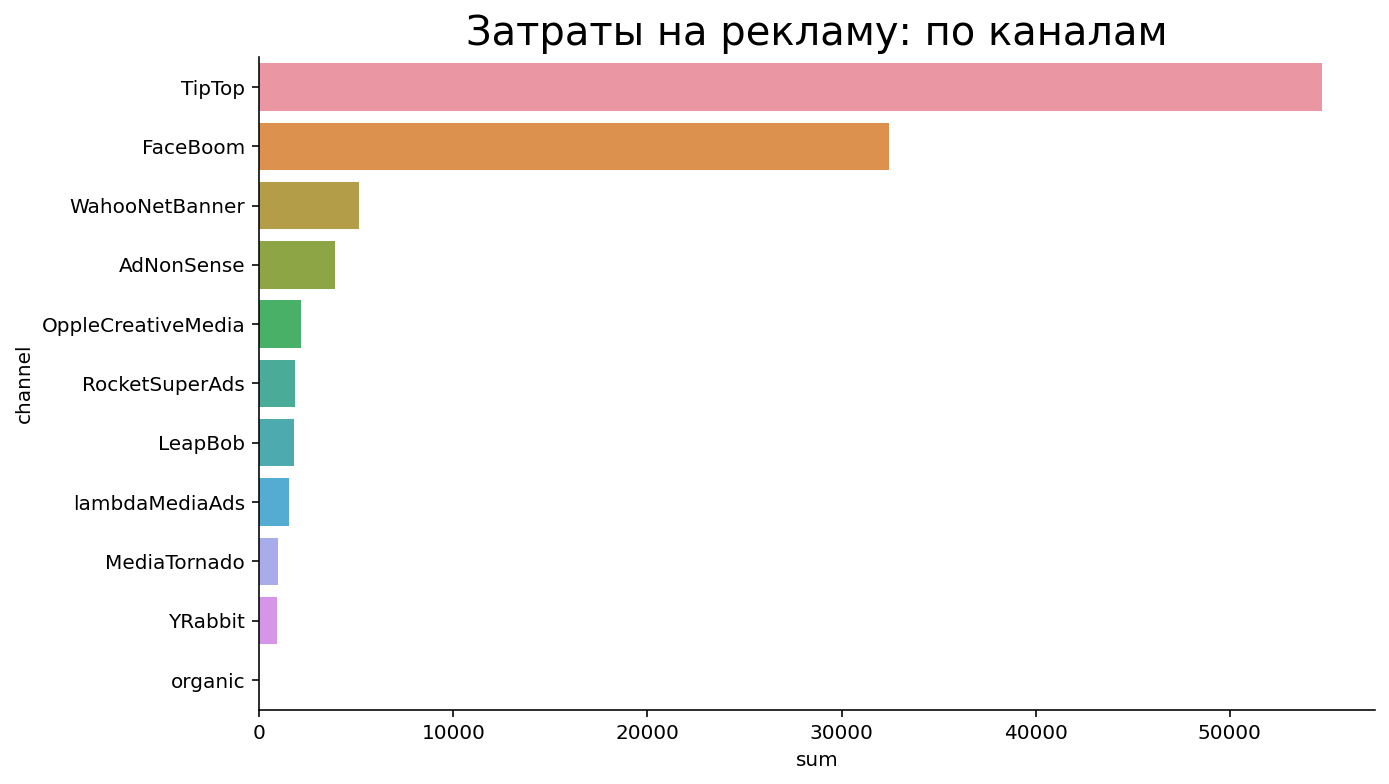

In [37]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="sum", y="channel", data=channel_costs)
plt.title('Затраты на рекламу: по каналам', fontsize=20)
sns.set_palette('deep') 
sns.despine()

Больше всего денег было потрачено на **2 канала: TipTop (почти 55 тысяч) и FaceBoom	(почти 32,5 тысячи).**

In [38]:
sum_costs = costs['costs'].sum()
print('Общие затраты на рекламу составляют:', round(sum_costs, 2))

Общие затраты на рекламу составляют: 105497.3


In [39]:
profiles.query('payer == True')['acquisition_cost'].sum()


10403.8101811756

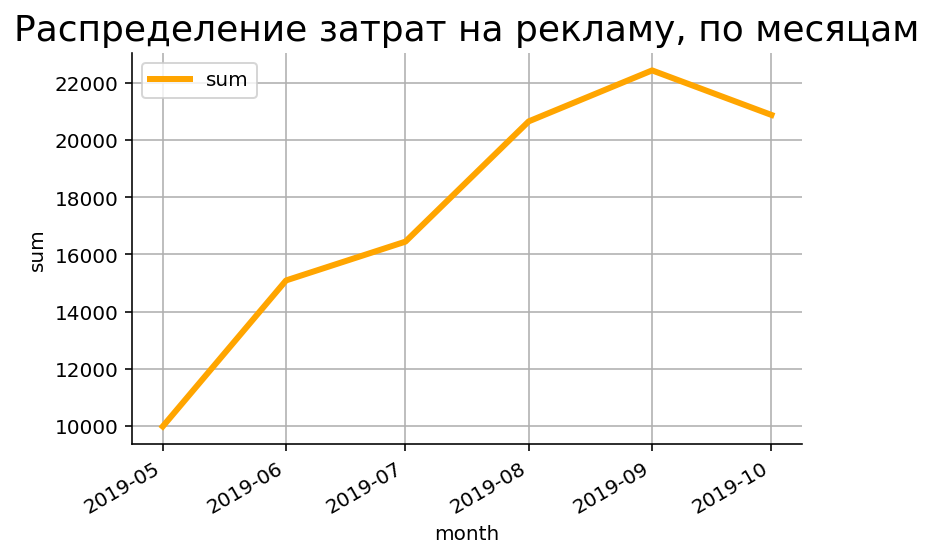

In [40]:
#Распределение затрат на рекламу по месяцам
time_costs = profiles.groupby('month')['acquisition_cost'].agg({'sum'}).reset_index().sort_values(by='sum', ascending=False)

time_costs.plot(x='month', y='sum', color="orange", style='-', linewidth=3, grid=True, ylabel = 'sum') 
plt.title('Распределение затрат на рекламу, по месяцам', fontsize=18)

sns.despine()

**С мая по сентябрь 2019 года** затраты на рекламу выросли **с 10 тысяч до 22 тысяч**; в октябре они немного снизились и достигли **20,8 тысяч.** Я не пишу размерность затрат (рубли или другая валюта), так как, к сожалению, в задании исследования этот момент не указан.

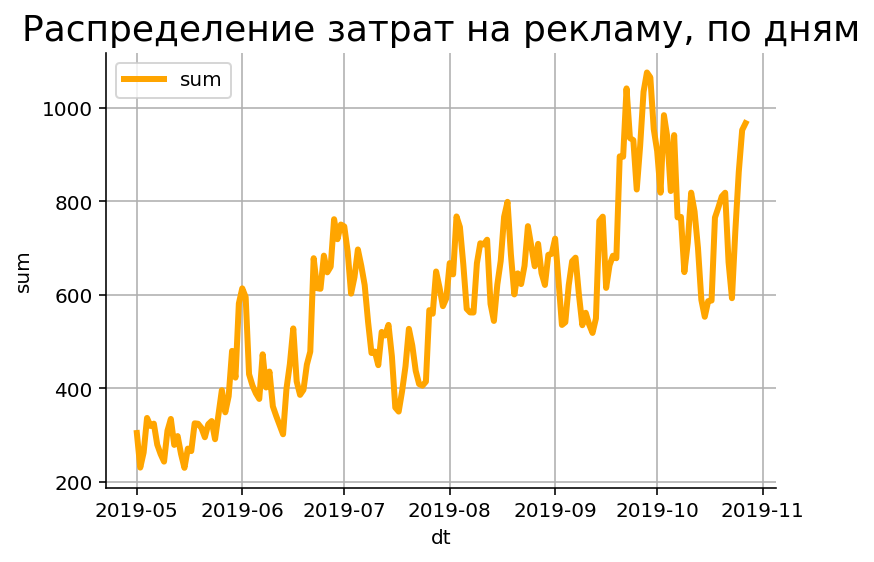

In [41]:
#Распределение затрат на рекламу по дням
time_costs = profiles.groupby('dt')['acquisition_cost'].agg({'sum'}).reset_index().sort_values(by='sum', ascending=False)

time_costs.plot(x='dt', y='sum', color="orange", style='-', linewidth=3, grid=True, ylabel = 'sum') 
plt.title('Распределение затрат на рекламу, по дням', fontsize=18)

sns.despine()

Если рассматривать распределение затрат на рекламу по дням, то **можно увидеть пики в июне (600), в июле (750) и октябре (1100), после которых идет временное падение (300 - в середине июня; 350 - в середине июля; 550 - в середине октября)**. В конце ноября затраты на рекламу **начали снова расти и достигли 950**. **С августа по сентябрь** включительно затраты были **равномерные (в диапазоне от 600 до 800).**

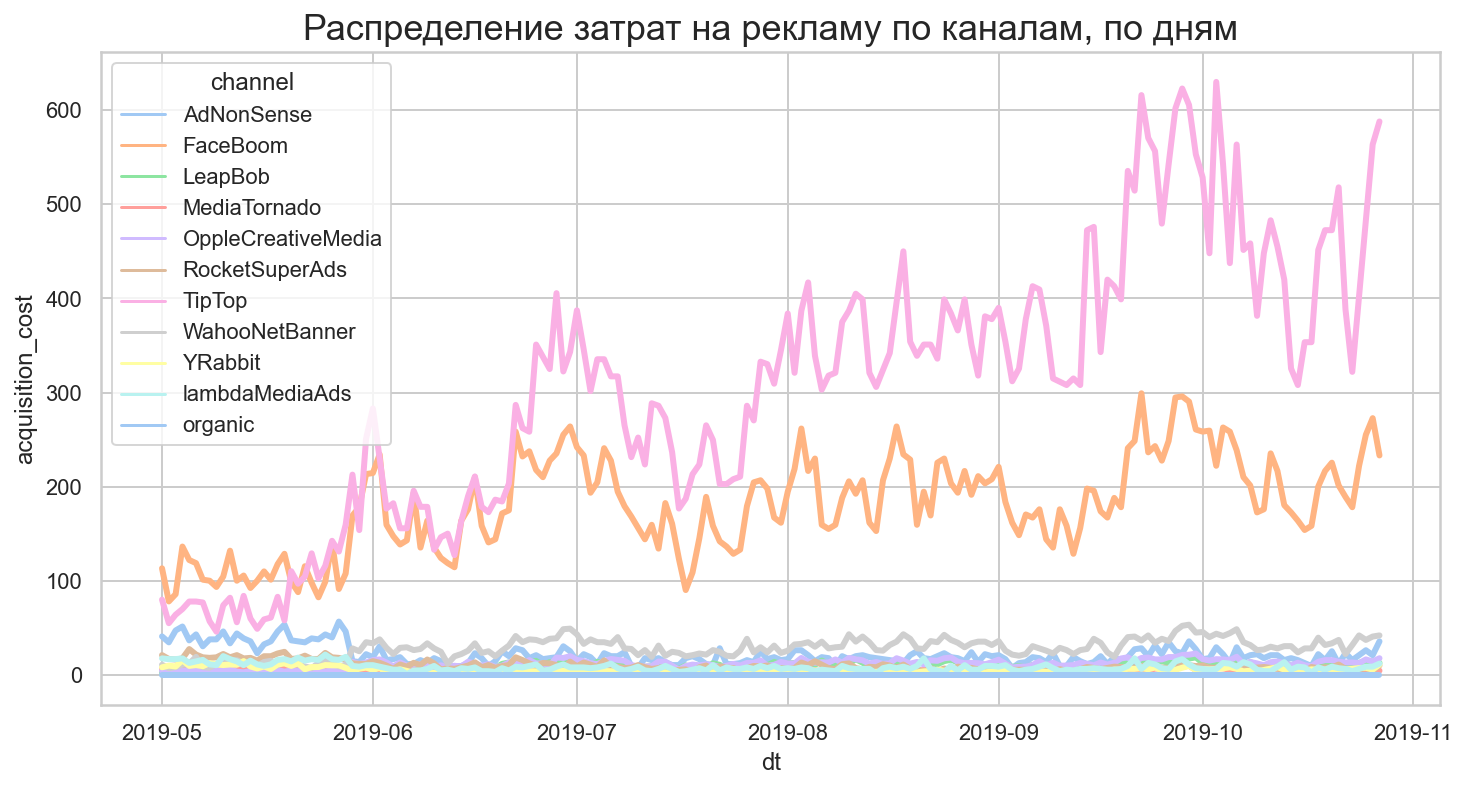

In [42]:
sns.set(style="whitegrid")
df_group_by_channel = profiles.groupby(['channel', 'dt'], as_index=False)[
    ['acquisition_cost']].sum()
t5_channel = list(
    df_group_by_channel.groupby(
        'channel',
        as_index=False).sum().sort_values(
            by='acquisition_cost',
        ascending=False).head(13)['channel'])
df_group_by_channel = df_group_by_channel[df_group_by_channel['channel'].isin(
    t5_channel)]
p1 = sns.lineplot(
    x='dt',
    y='acquisition_cost',
    hue='channel',
    linewidth=3,
    palette=sns.color_palette("pastel", n_colors=11),
    data=df_group_by_channel)
fig = p1.get_figure()
plt.title('Распределение затрат на рекламу по каналам, по дням', fontsize=18)
fig.set_size_inches(12, 6)
plt.show()

In [43]:
#очистим датафрейм от 'органических' пользователей
non_organic_profiles = profiles[profiles['channel'] != "organic"]
number_of_payers = non_organic_profiles['user_id'].count()

#посчитаем среднюю стоимость привлечения одного пользователя
cac_one_user = round(general_costs / number_of_payers, 2) #general_costs - общие затраты на маркетинг
print('Средняя стоимость привлечения одного пользователя:', cac_one_user)

Средняя стоимость привлечения одного пользователя: 1.13


In [44]:
#посчитаем средний CAC на одного пользователя по каналам
mean_costs_by_channel = non_organic_profiles.pivot_table(
    columns='channel', values='acquisition_cost', aggfunc='mean'
).T.sort_values(by='acquisition_cost', ascending=False).reset_index()
mean_costs_by_channel

channel  acquisition_cost
0              TipTop          2.799003
1            FaceBoom          1.113286
2          AdNonSense          1.008054
3      lambdaMediaAds          0.724802
4      WahooNetBanner          0.602245
5      RocketSuperAds          0.412095
6  OppleCreativeMedia          0.250000
7             YRabbit          0.218975
8        MediaTornado          0.218717
9             LeapBob          0.210172

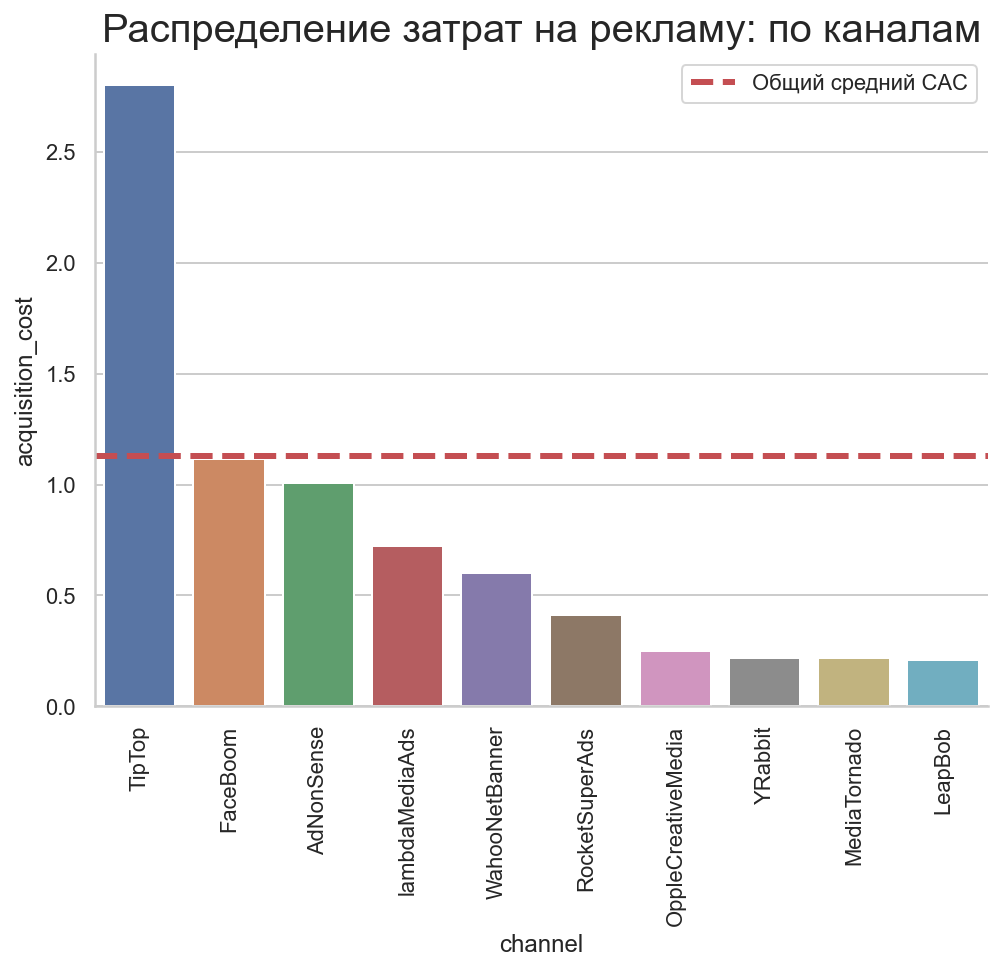

In [45]:
plt.figure(figsize=(8, 6))
sns.barplot(x="channel", y="acquisition_cost", data=mean_costs_by_channel)
plt.axhline(cac_one_user, color='r', linestyle='dashed', linewidth=3, label='Общий средний CAC') 
plt.xticks(rotation='vertical')
plt.title('Распределение затрат на рекламу: по каналам', fontsize=20)
plt.legend()
sns.set_palette('deep') 
sns.despine()

**Общий CAC на одного пользователя составляет 1.13.** Стоимость привлечения во всех каналах за исключением TipTop ниже общего CAC. Показатель CAC **для канала TipTop значительно превышает среднюю стоимость** привлечения и **составляет 2.8.**

### Оценка окупаемости рекламы для привлечения пользователей

Используя графики LTV, ROI и CAC, проанализируйте окупаемость рекламы. Считайте, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определите самостоятельно.

- Проанализируйте общую окупаемость рекламы. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

Опишите обнаруженные проблемы и напишите промежуточные выводы.

- Постройте и изучите графики конверсии и удержания с разбивкой по устройствам, странам, рекламным каналам.

Ответьте на такие вопросы:

- Окупается ли реклама в целом?
- Какие устройства, страны и каналы могут снижать окупаемость рекламы?
- Чем могут быть вызваны проблемы окупаемости?

Опишите возможные причины обнаруженных проблем и промежуточные рекомендации для рекламного отдела.

#### Общая окупаемость рекламы

In [46]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 

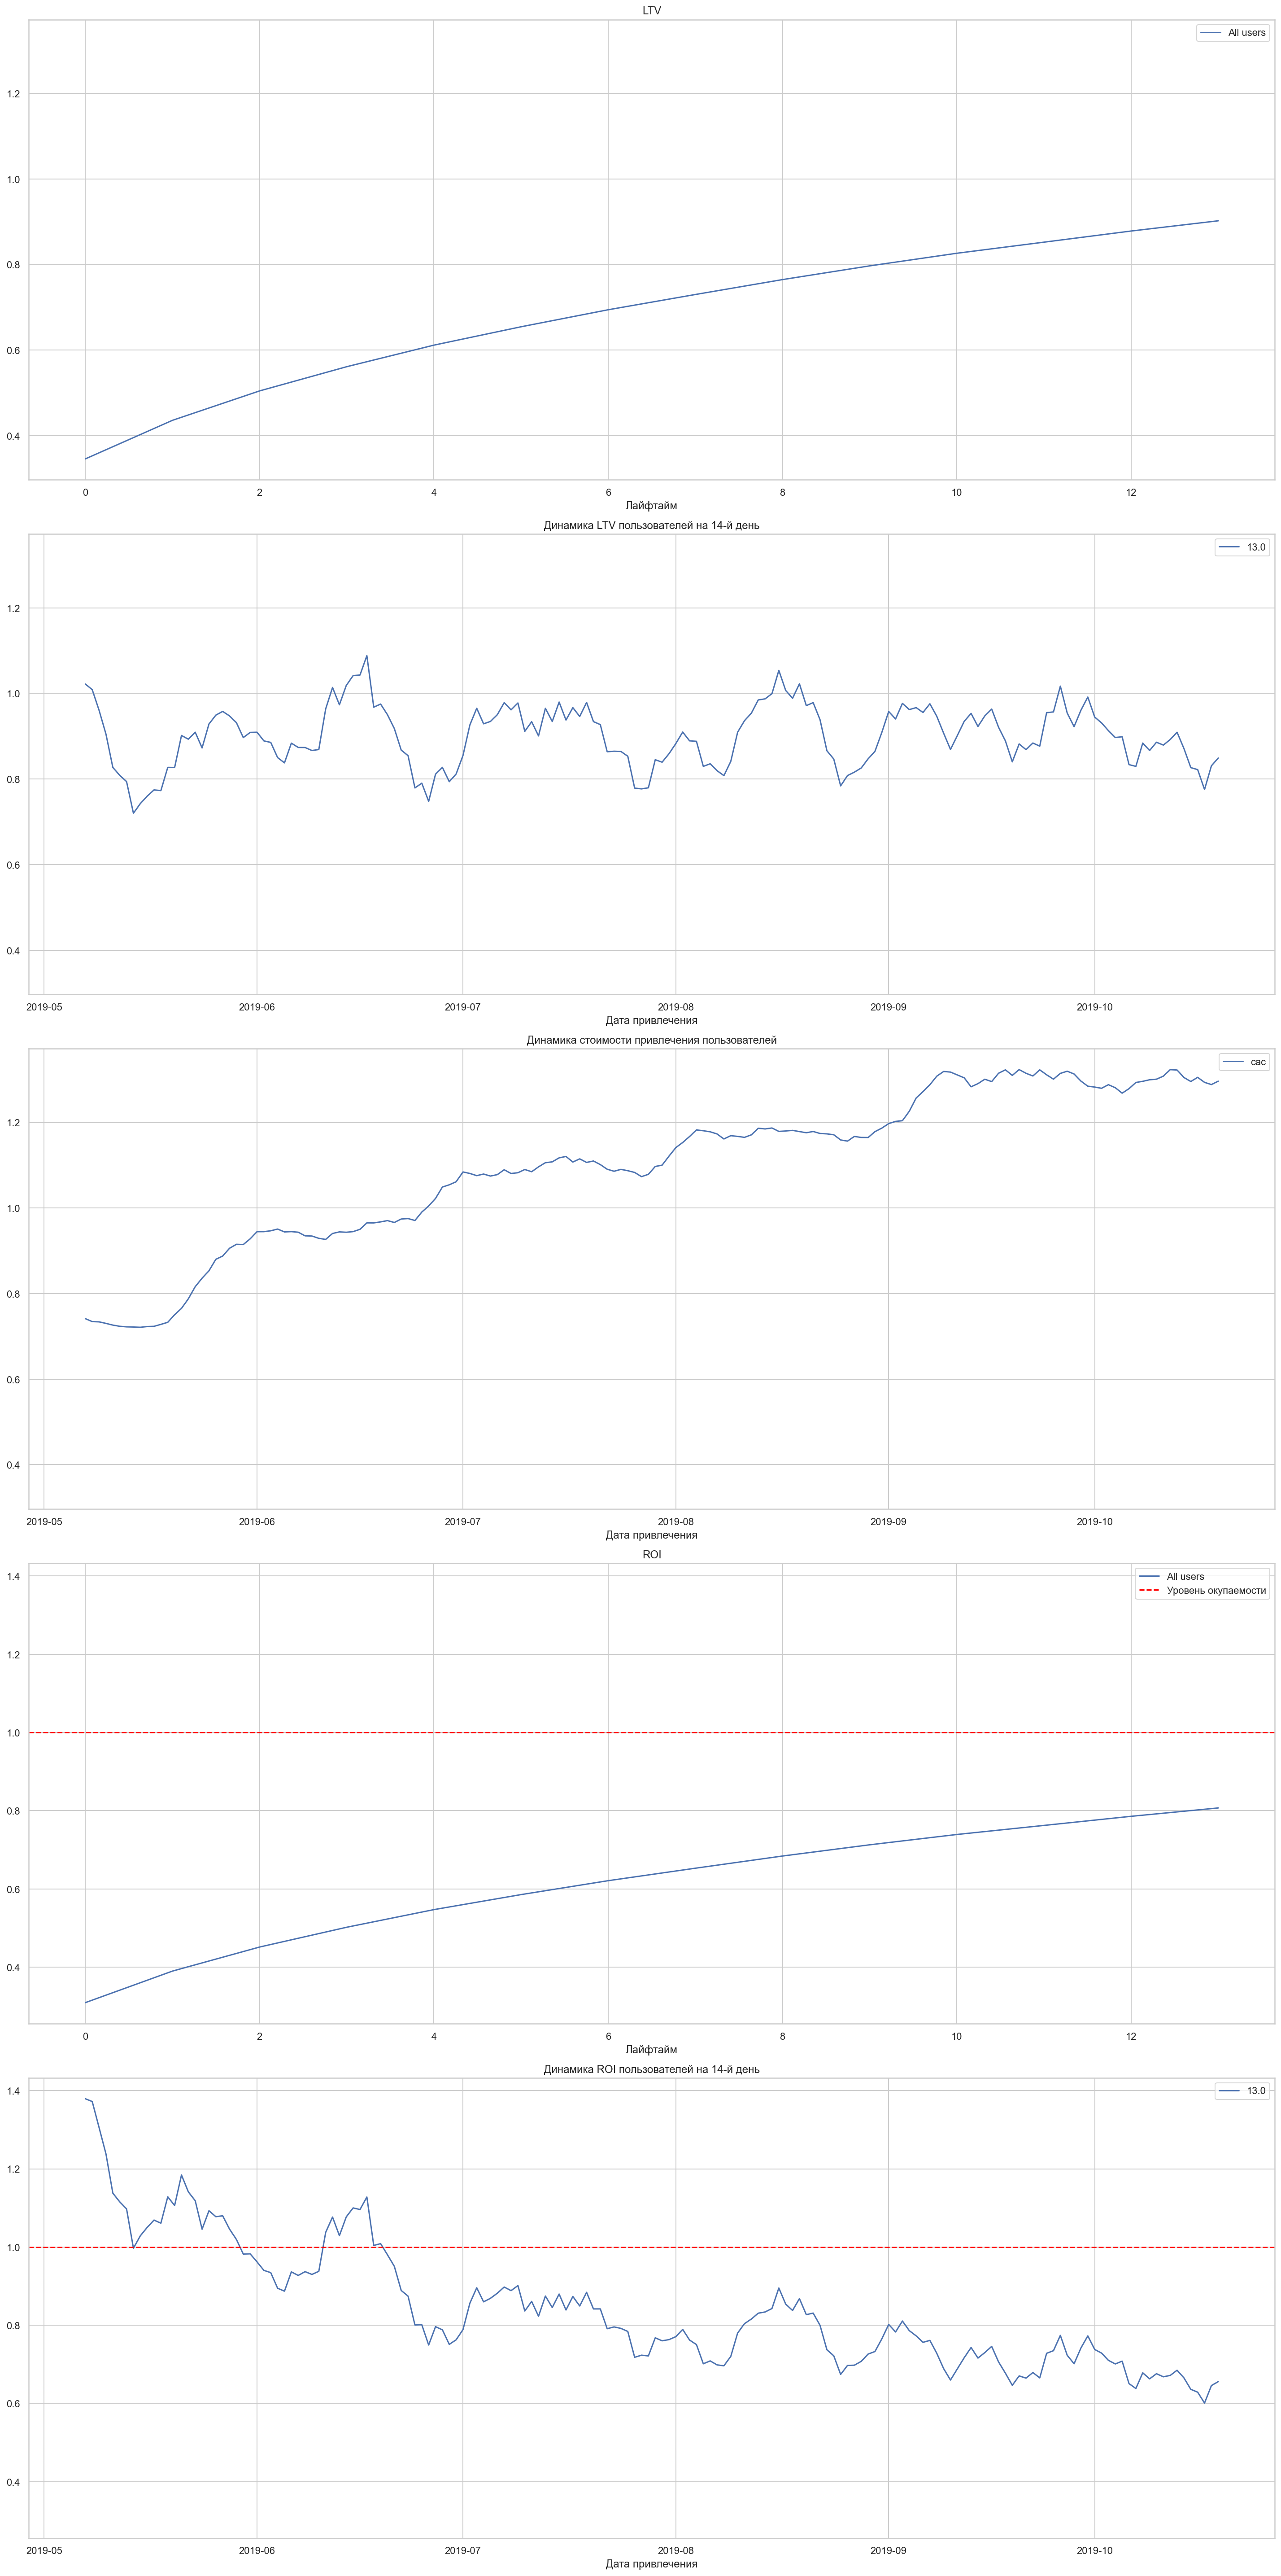

In [47]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    non_organic_profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

По графикам **общей окупаемости** можно сделать такие выводы:
- **LTV к концу 2й недели равен 90%**
- Реклама не окупается. ROI в конце 2й недели составляет 80%. В мае и середине июня рекламные затраты окупались, но в дальнейшем с каждым месяцем окупаемость снижается.
- LTV показатель достаточно стабилен на протяжении всего исследуемого периода. **Значит, дело не в ухудшении качества пользователей.**
- CAC нестабилен. **Возможно, дело в увеличении рекламного бюджета.**

#### Окупаемость рекламы с разбивкой по рекламным каналам

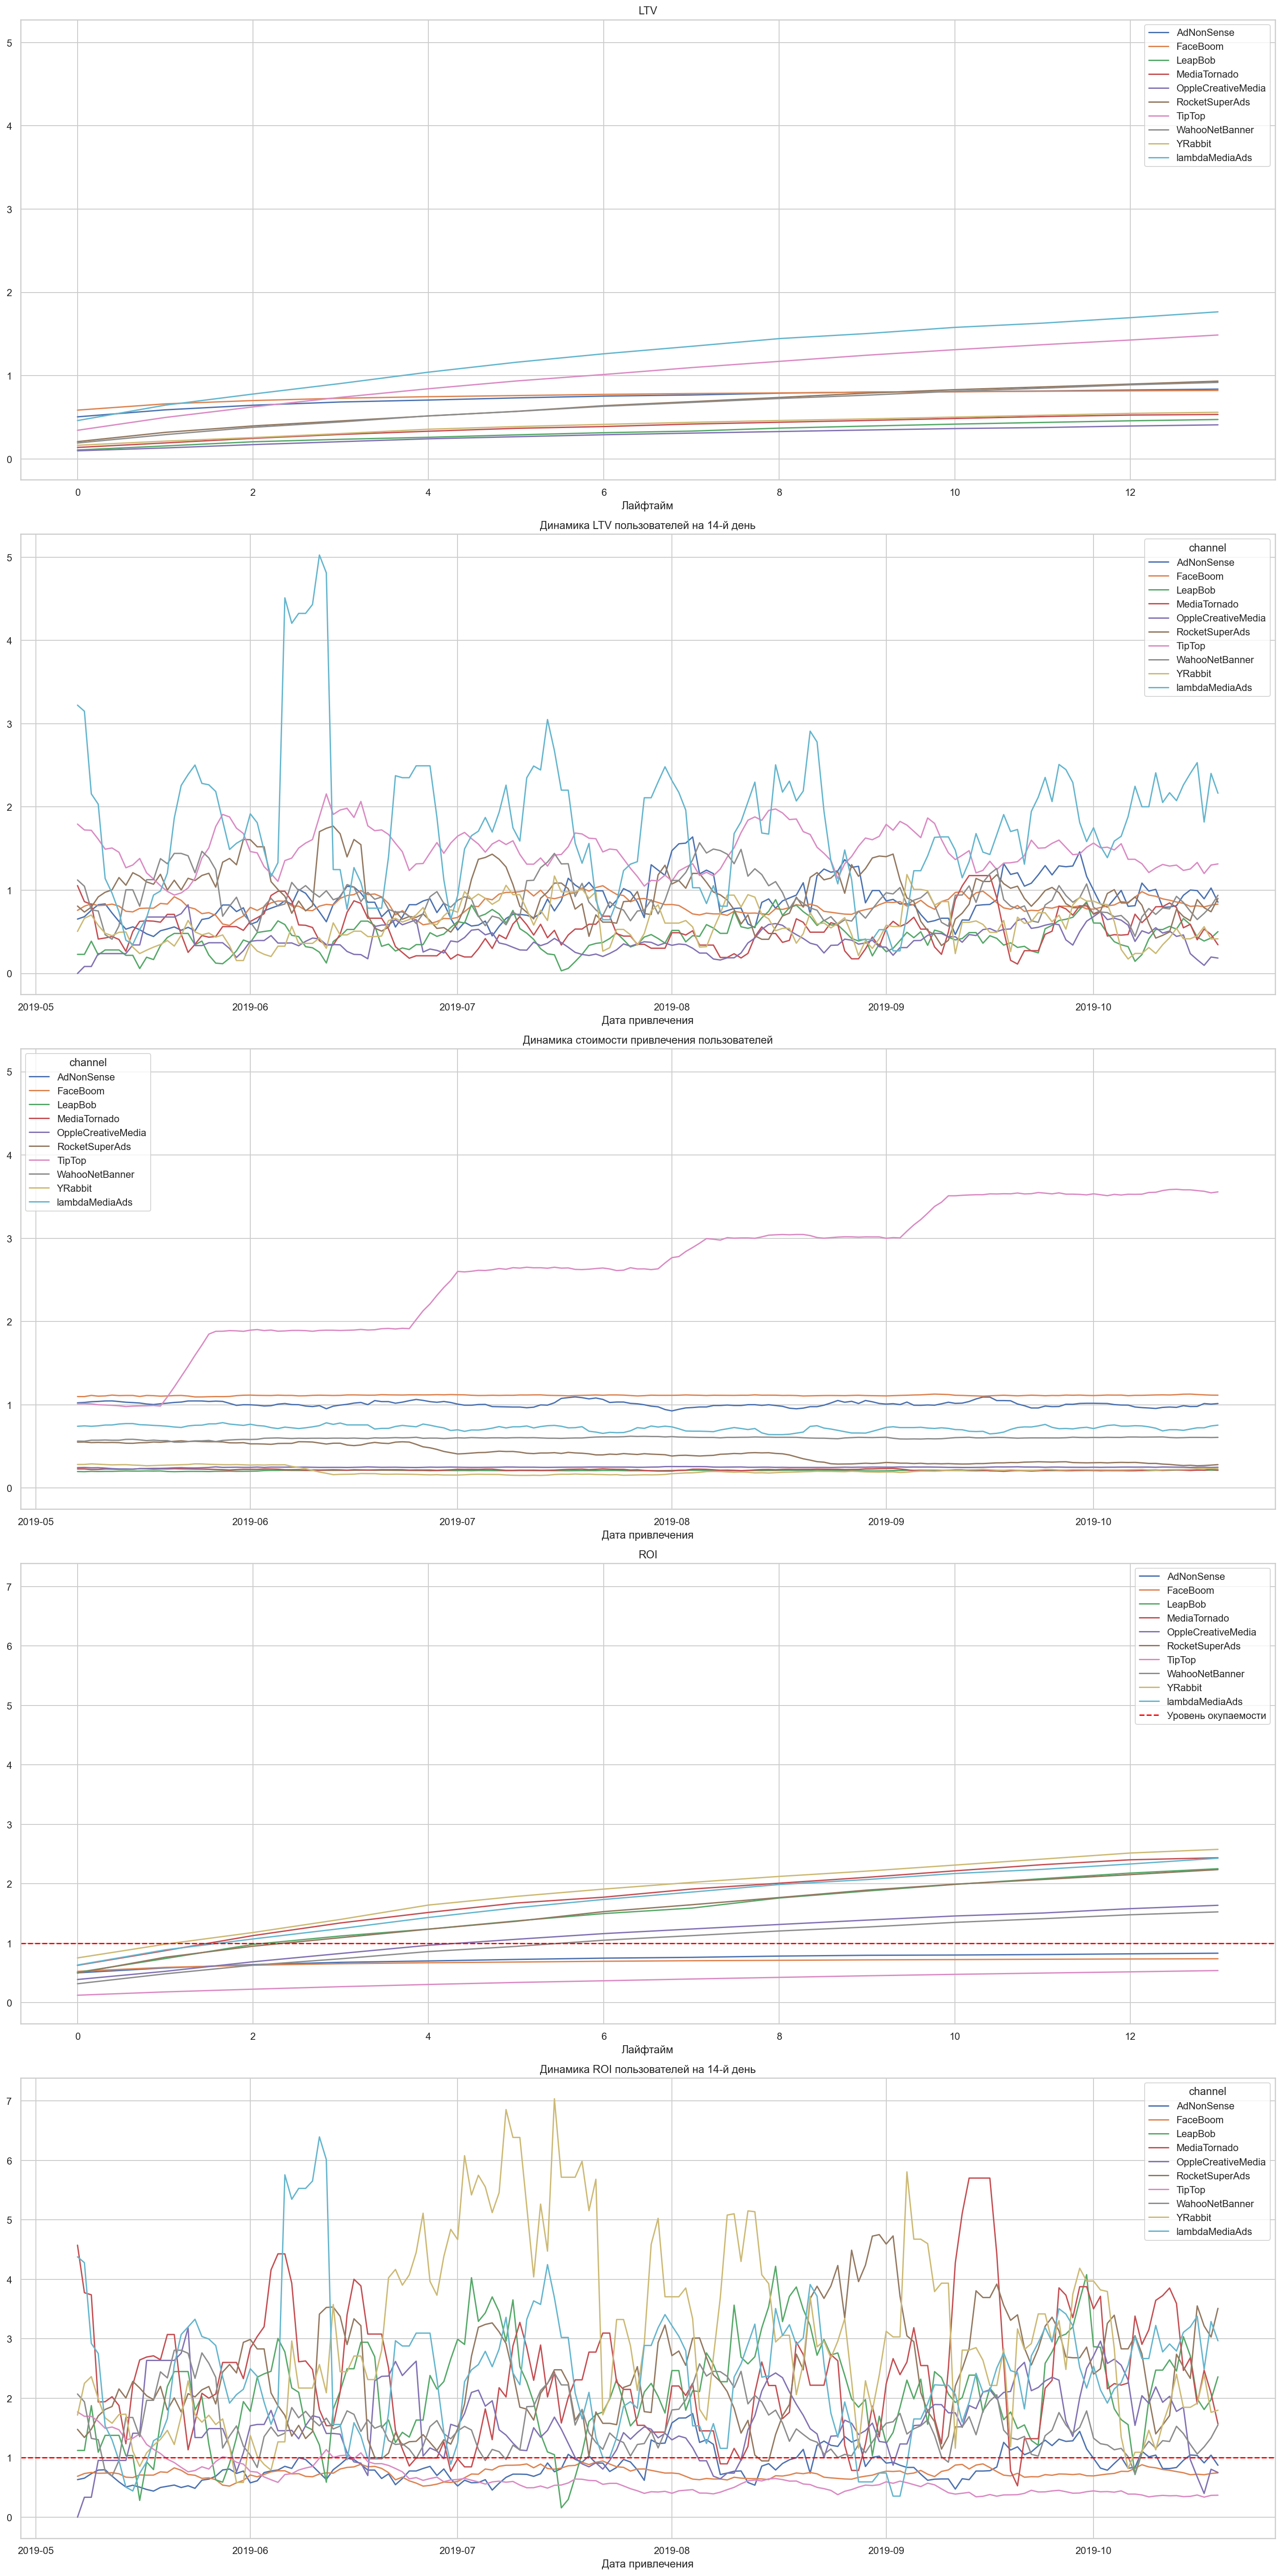

In [48]:
# считаем LTV и ROI
dimensions = ['channel']
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    non_organic_profiles, orders, observation_date, horizon_days, dimensions = dimensions
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

По графикам окупаемости в **разрезе каналов привлечения** можно сделать такие выводы:
- **LTV к концу 2й недели выше 100% только у канала TipTop и lambdaMediaAds.** Если рассматривать LTV в динамике, то самый высокий наблюдается у lambdaMediaAds на протяжении практически всего рассматриваемого периода. В июне он достигал 4,5-5 пунктов, когда в остальных каналах он находился в диапазоне от 0 до 2. Это означает, что через канал lambdaMediaAds приходят самые качественные пользователи ("покупающие").
- При этом, реклама окупается по всем каналам, кроме **TipTop, FaceBoom и AdNonSense**. ROI в конце 2й недели по всем остальным каналам **составляет 150-200% (выручка превышает маркетинговые затраты в 1,5-2 раза)**.
- Рассматривая ROI в динамике, мы видим, что **максимум окупаемости достигаем в канале YRabbit в период с середины июня по середину августа (более 7 пунктов в середине июля), а также в канале lambdaMediaAds (в первой половине июня 6,4 пунктов) и MediaTornado (в середине сентября 5,7 пунктов).** 
- **CAC стабилен во всех каналах, кроме TipTop**. Его динамика ступенчатая от месяца к месяцу. **Это значит, что именно в этот канал вливают каждый месяц все больше и больше денег.**

#### Окупаемость рекламы с разбивкой по странам

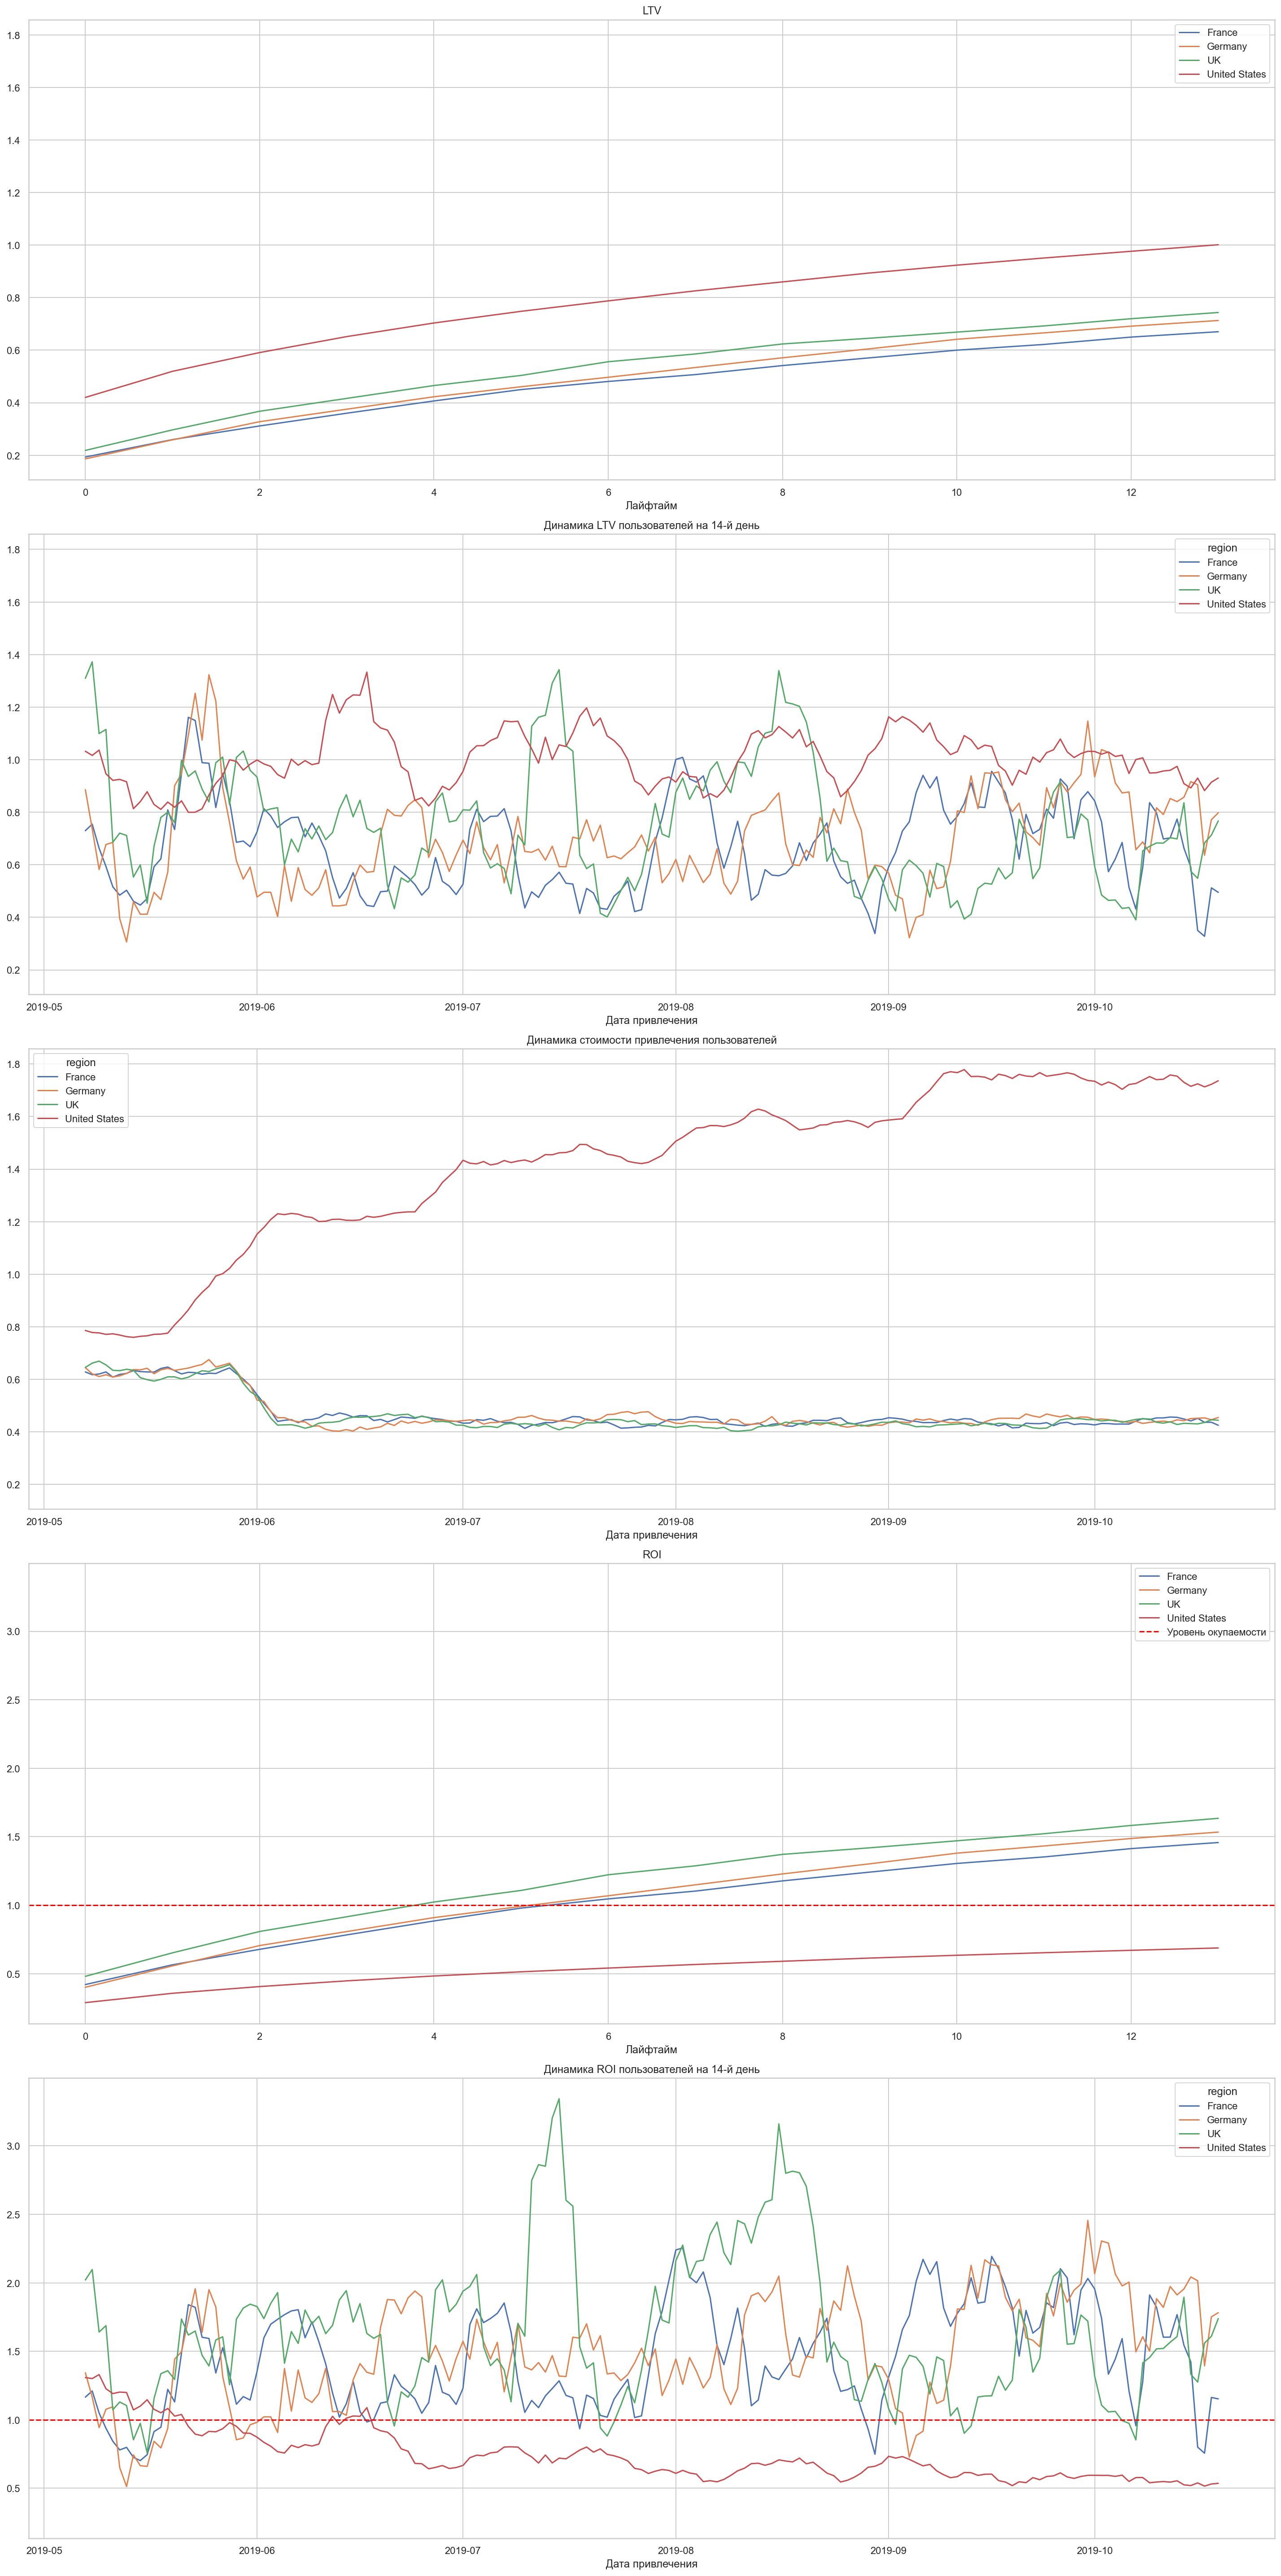

In [49]:
# считаем LTV и ROI
dimensions = ['region']
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    non_organic_profiles, orders, observation_date, horizon_days, dimensions = dimensions
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

По графикам окупаемости в **разрезе стран** можно сделать такие выводы:
- **LTV к концу 2й недели достигает 100% только в США.** Если рассматривать LTV в динамике, то самый стабильный наблюдается как раз в США (в диапазоне от 0,8 до 1,35). Самая высокая волатильность и максимальные значения LTV - у Великобритании (от 0,4 до 1,4). **Это означает, что из стран США и Великобритания приходят самые качественные пользователи ("покупающие").**
- **Стабильный CAC наблюдается у всех стран (0,4 пункта), кроме США**. **Стоимость привлечения пользователей из стран США** на рассматриваемом временном периоде растет месяц к месяцу и к концу октября **достигает 1,7 пунктов.** Это значит, что именно в привлечение пользователей из этой страны компания платит больше всего денег.
- Что любопытно, это именно привлечение пользователей из США совершенно не окупается, **в отличие от других стран, у которых ROI находится в районе 1,5 пунктов (выручка превышает маркетинговые затраты в 1,5 раза)**.
- Рассматривая ROI в динамике, мы видим, что с каждым месяцем окупаемость привлечения пользователей из США снижается. **У остальных стран практически на всем периоде показатель находится выше уровня окупаемости. Максимальные значения наблюдаются у Великобритании (3,2 и 3,3 пункта в середине июля и середине августа).** 

#### Окупаемость рекламы с разбивкой по устройствам

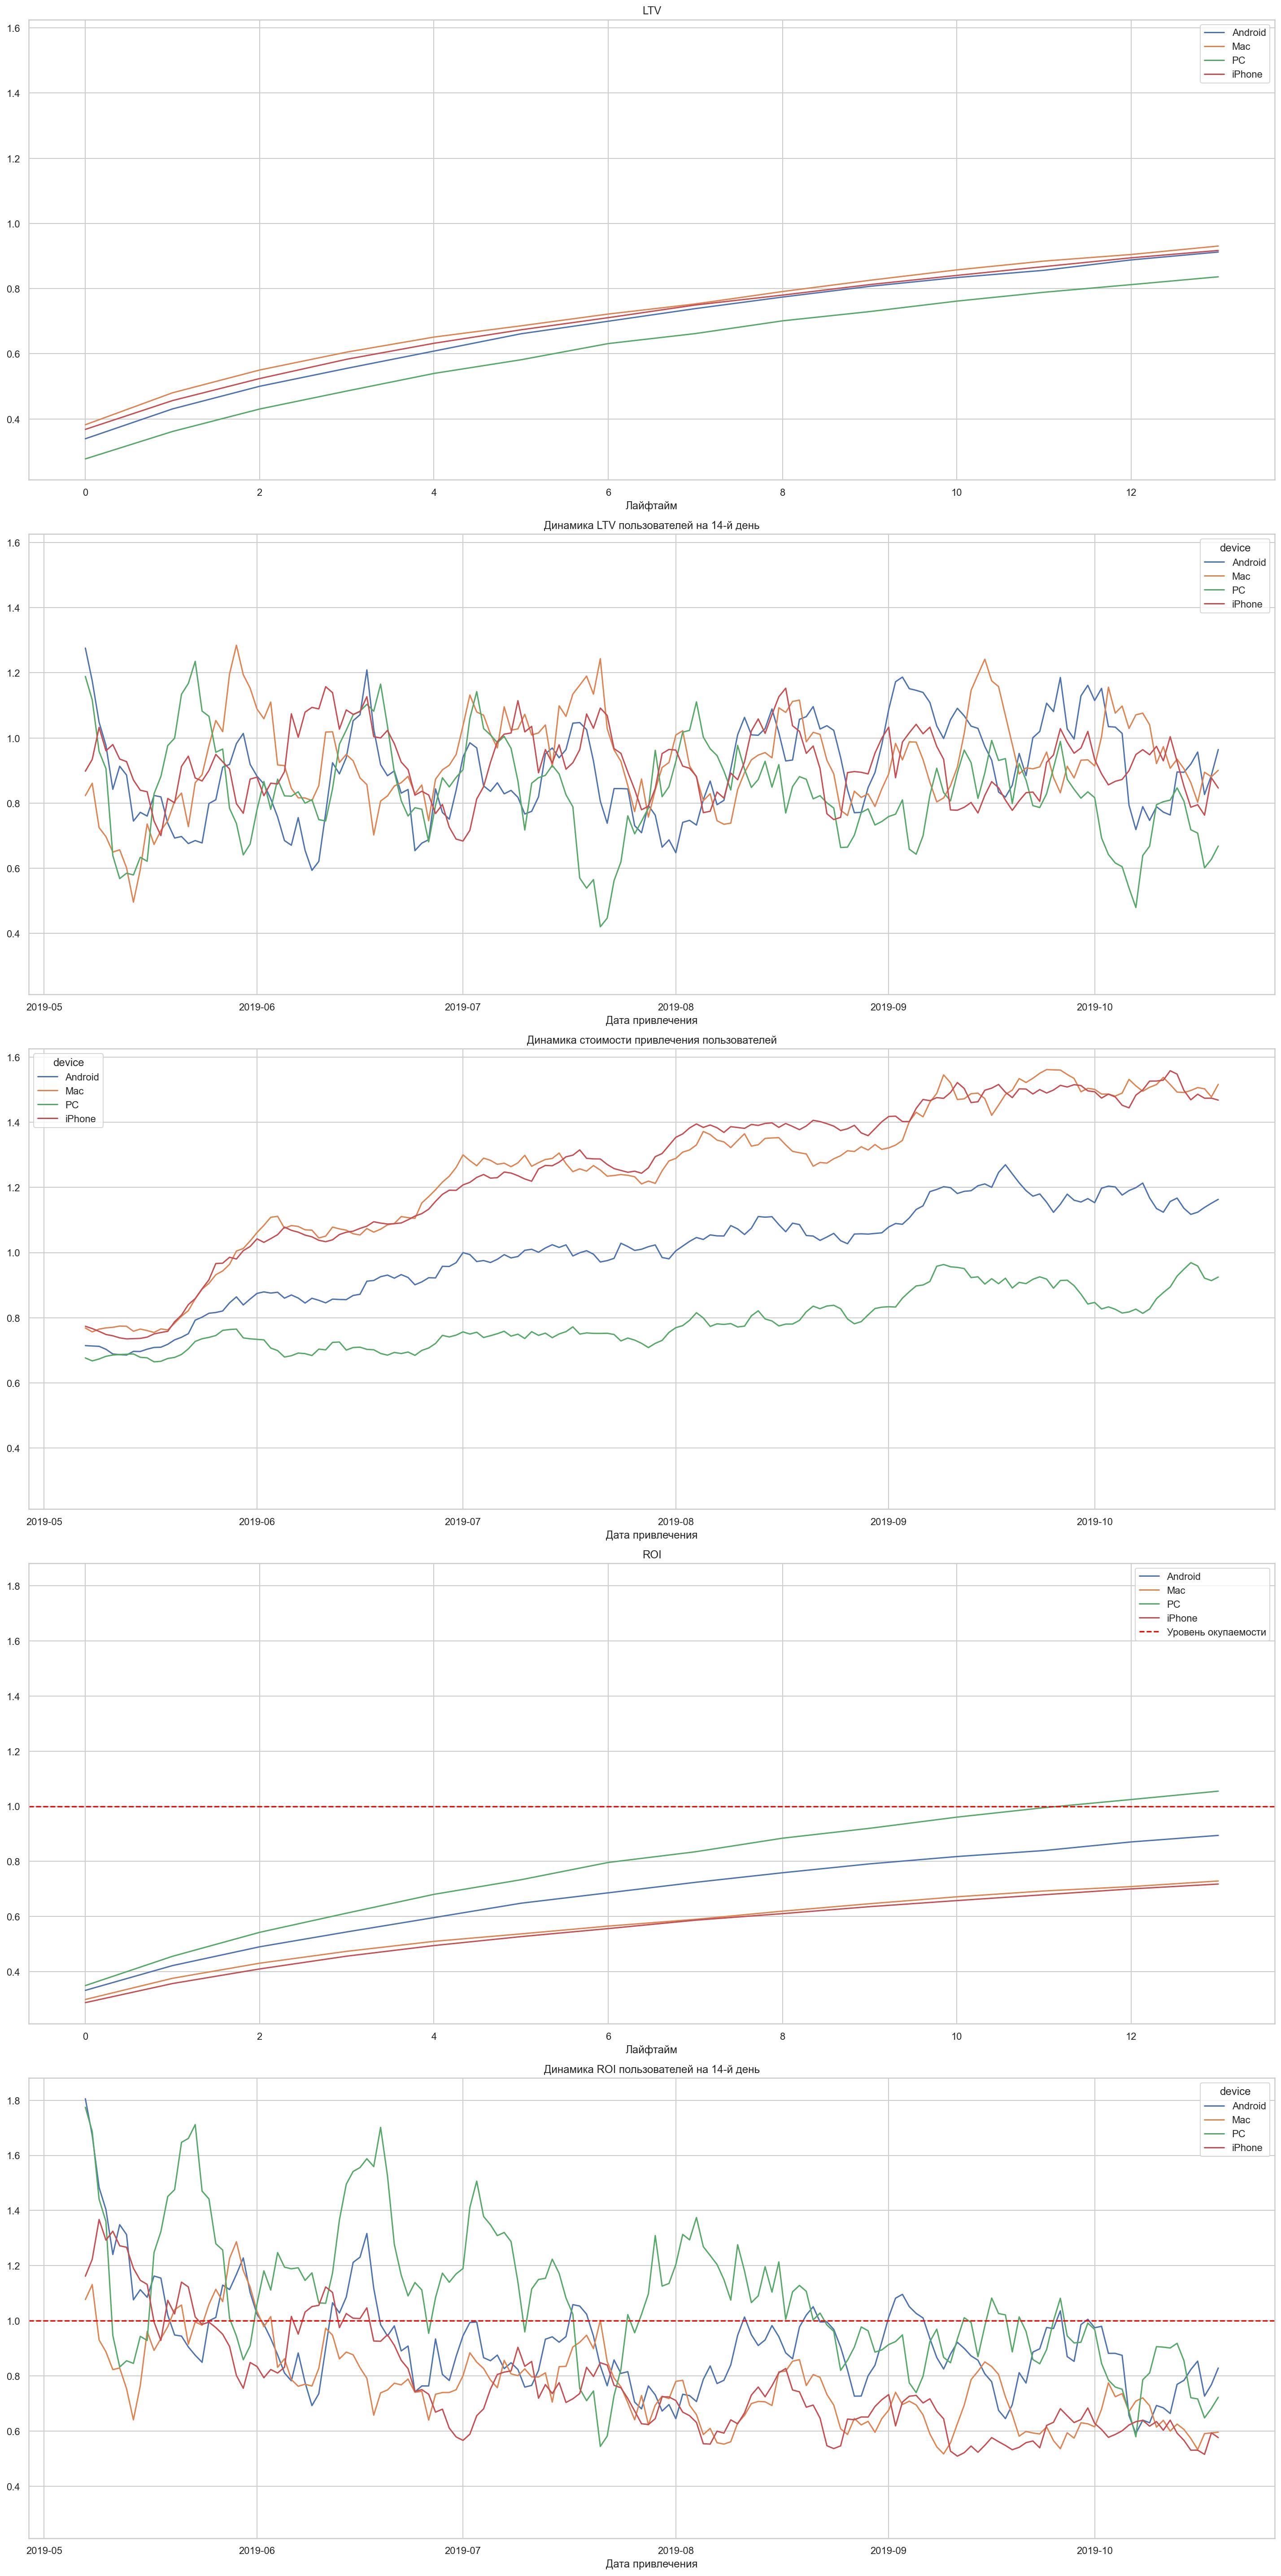

In [50]:
# считаем LTV и ROI
dimensions = ['device']
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    non_organic_profiles, orders, observation_date, horizon_days, dimensions = dimensions
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

По графикам окупаемости в **разбивке по устройствам** можно сделать такие выводы:
- **LTV к концу 2й недели достигает 90% у всех устройств, кроме PC (85%).** Если рассматривать LTV в динамике, то самый нестабильный наблюдается как раз у **PC (в диапазоне от 0,45 до 1,25).** Самая высокая волатильность и максимальные значения LTV **у Mac (от 0,5 до 1,3)**. Самая низкая волатильность наблюдается у устройств **iPhone и Android: в диапазоне от 0,7 до 1,15 и от 0,6 до 1,2 соответственно.** По результатам анализа первых двух графиков, делаем вывод, что **через устройства Mac приходят самые качественные пользователи ("покупающие").**
- **CAC у всех устройств нестабильный: он растет от месяца к месяцу**. **Самое дорогое** привлечение пользователей происходит через устройства **Mac и iPhone (1,5 пунктов к концу периода), самое дешевое - у PC (0,9 пунктов** к концу рассматриваемого периода).
- Что любопытно, к концу второй недели привлечение пользователей **только через устройства PC** окупается и составляет **почти 1,1**. Самыми убыточными являются устройства **Mac и iPhone**.
- Рассматривая ROI в динамике, мы видим, что с каждым месяцем окупаемость привлечения пользователей через все устройства снижается. **Безубыточность устройств PC достигалось только за счет первых 2/3 рассматриваемого периода (с мая по середину августа).** Далее и у него доходность уходит ниже уровня окупаемости. Нужно разобраться, с чем это связано.

#### Графики конверсии и удержания с разбивкой по устройствам, странам, рекламным каналам

##### Графики конверсии и удержания с разбивкой по устройствам

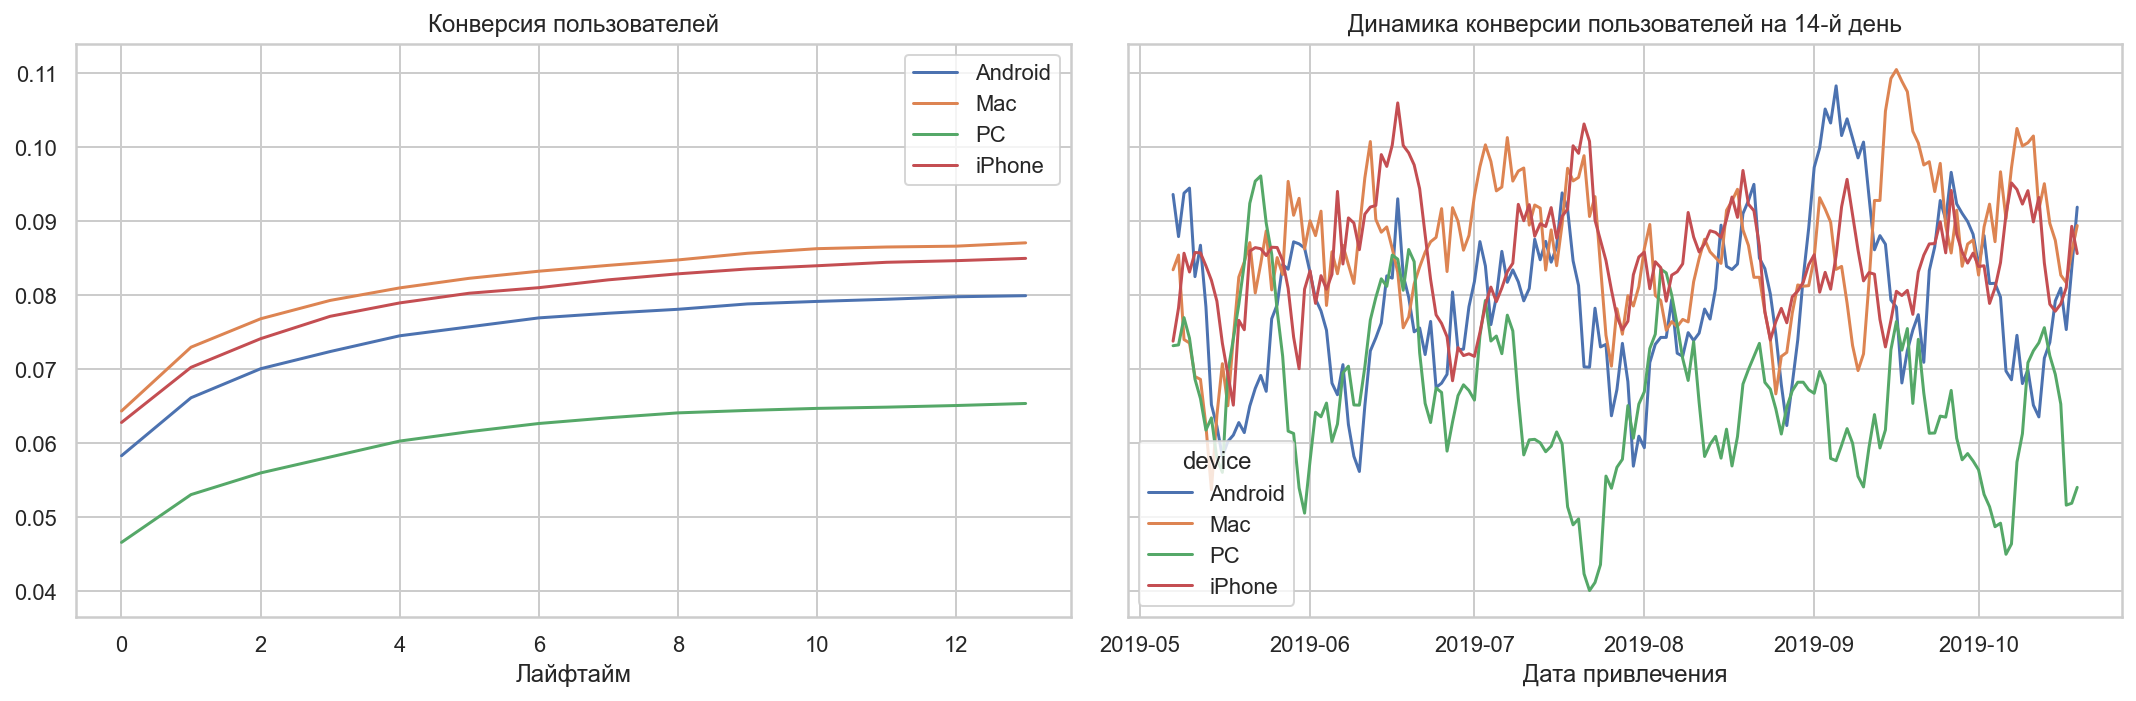

In [51]:
#рассмотрим конверсию с разбивкой по устройствам
dimensions = ['device']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    non_organic_profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Судя по графикам, **пользователи Mac, iPhone и Android конвертируются очень хорошо, причём постоянно в диапазоне от 6% до 11%.** Что же касается **пользователей PC**, то у них конвертация чуть ниже **(в диапазоне от 4% до 9,5%).**

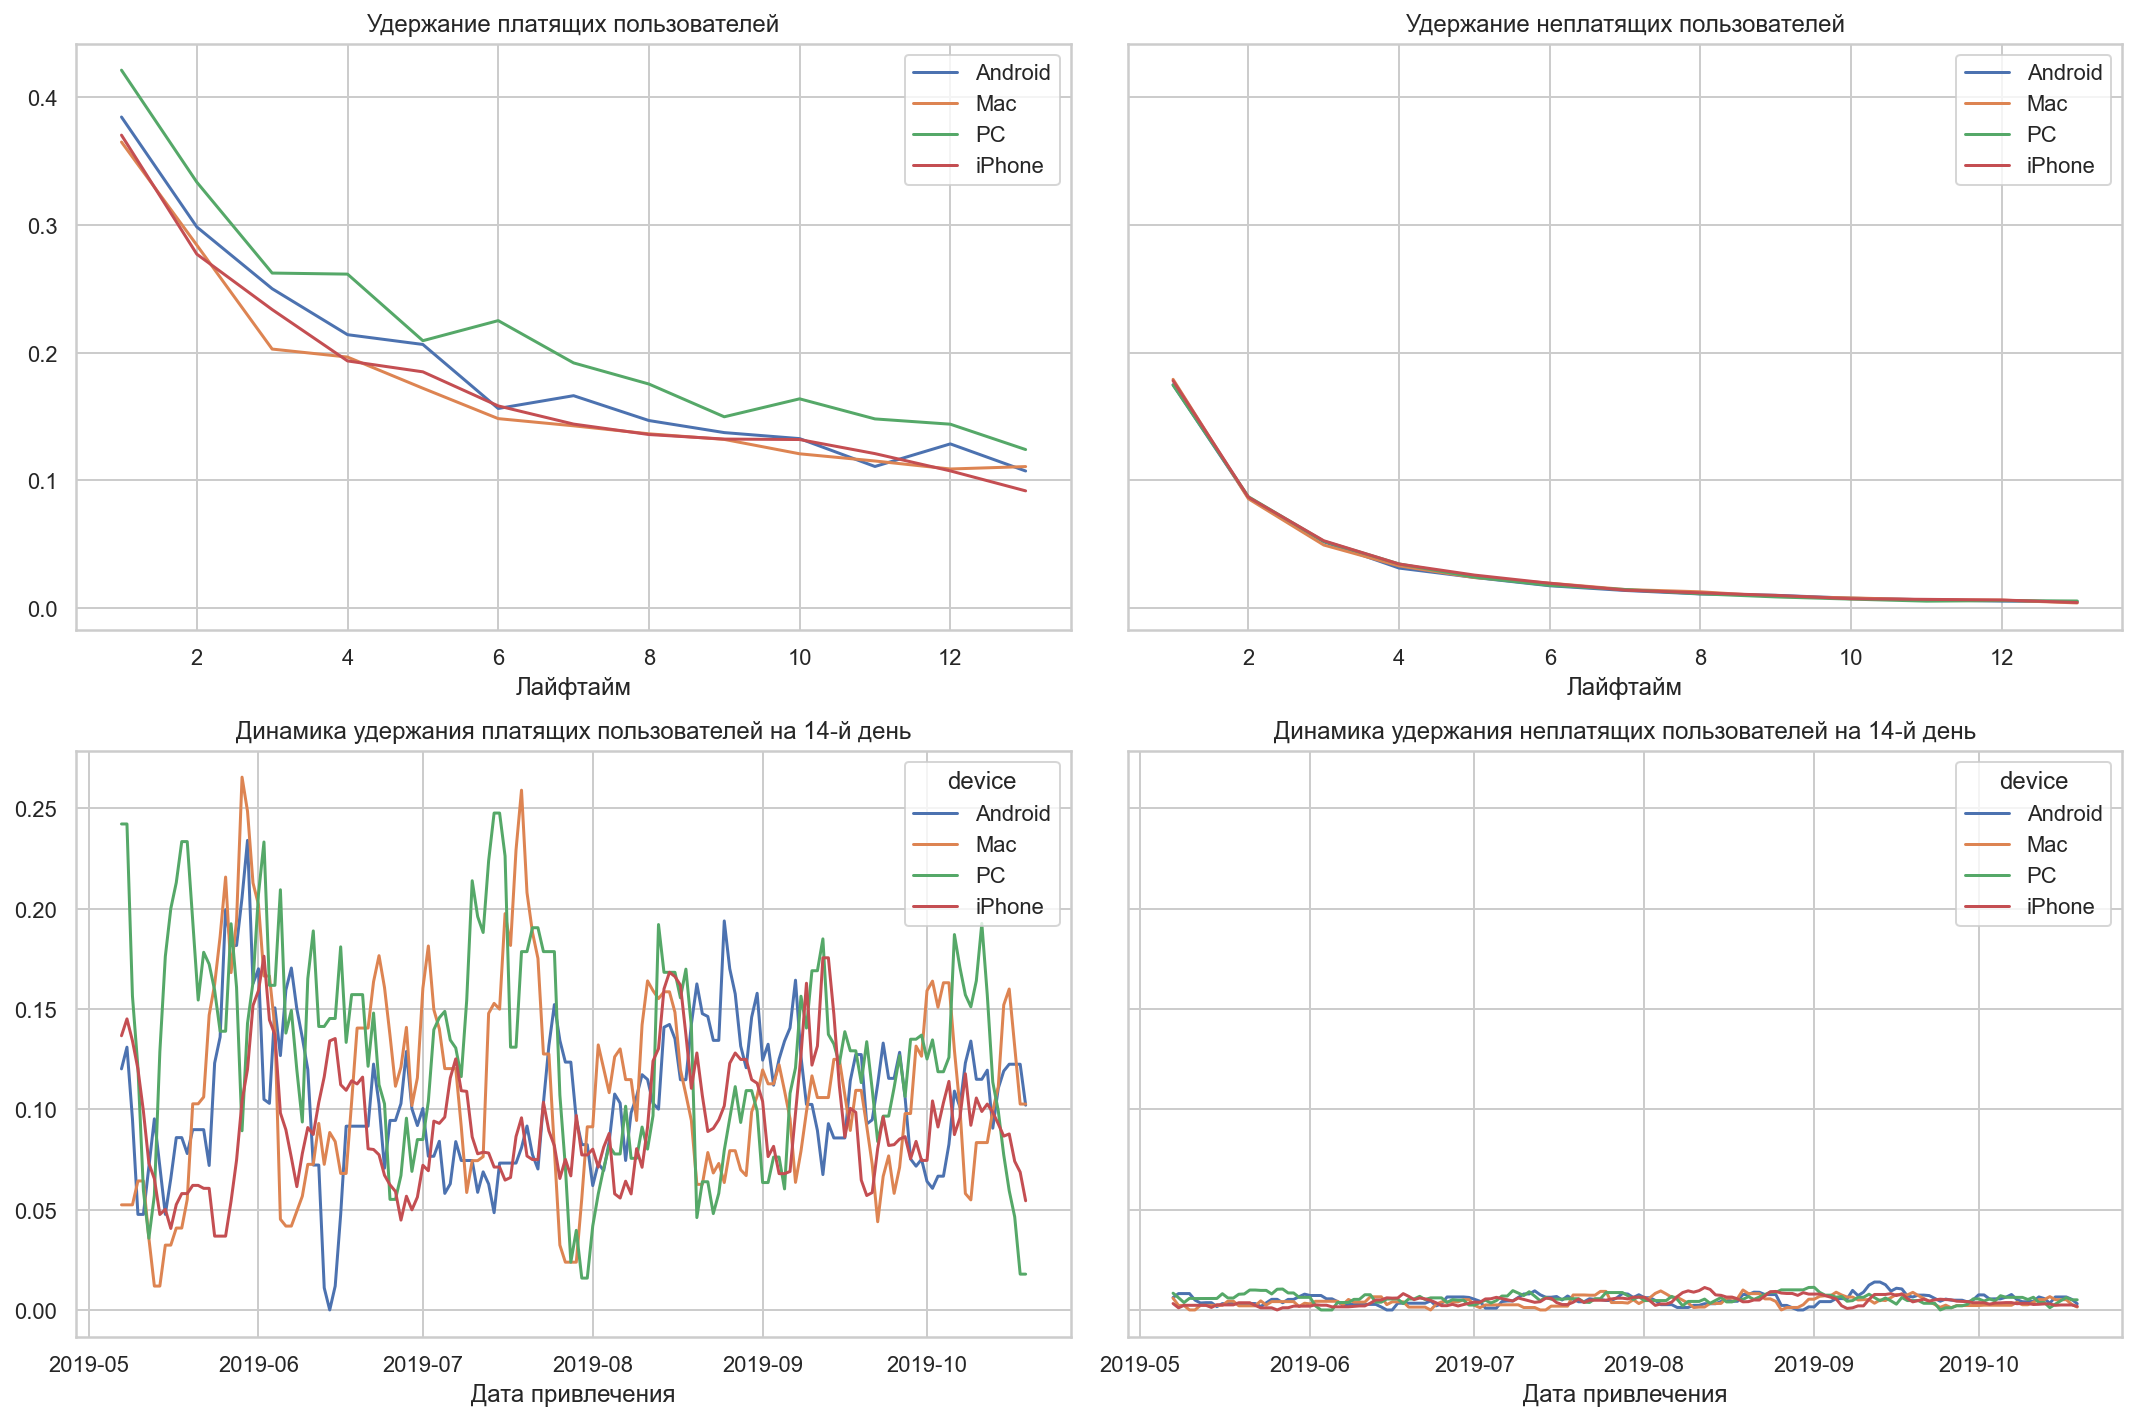

In [52]:
#рассмотрим удержание с разбивкой по устройствам
dimensions = ['device']
retention_raw, retention_grouped, retention_history = get_retention(
    non_organic_profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

В разрезе устройств удержание неплатящих пользователей значительно хуже платящих. Но и те, и другие очень плохо удерживаются. **Платящие пользователи к концу 2й недели сокращаются с 40% до 10% по всем девайсам.** Это очень низкий показатель.
Возможно, причина в какой-нибудь технической проблеме.

##### Графики конверсии и удержания с разбивкой по странам

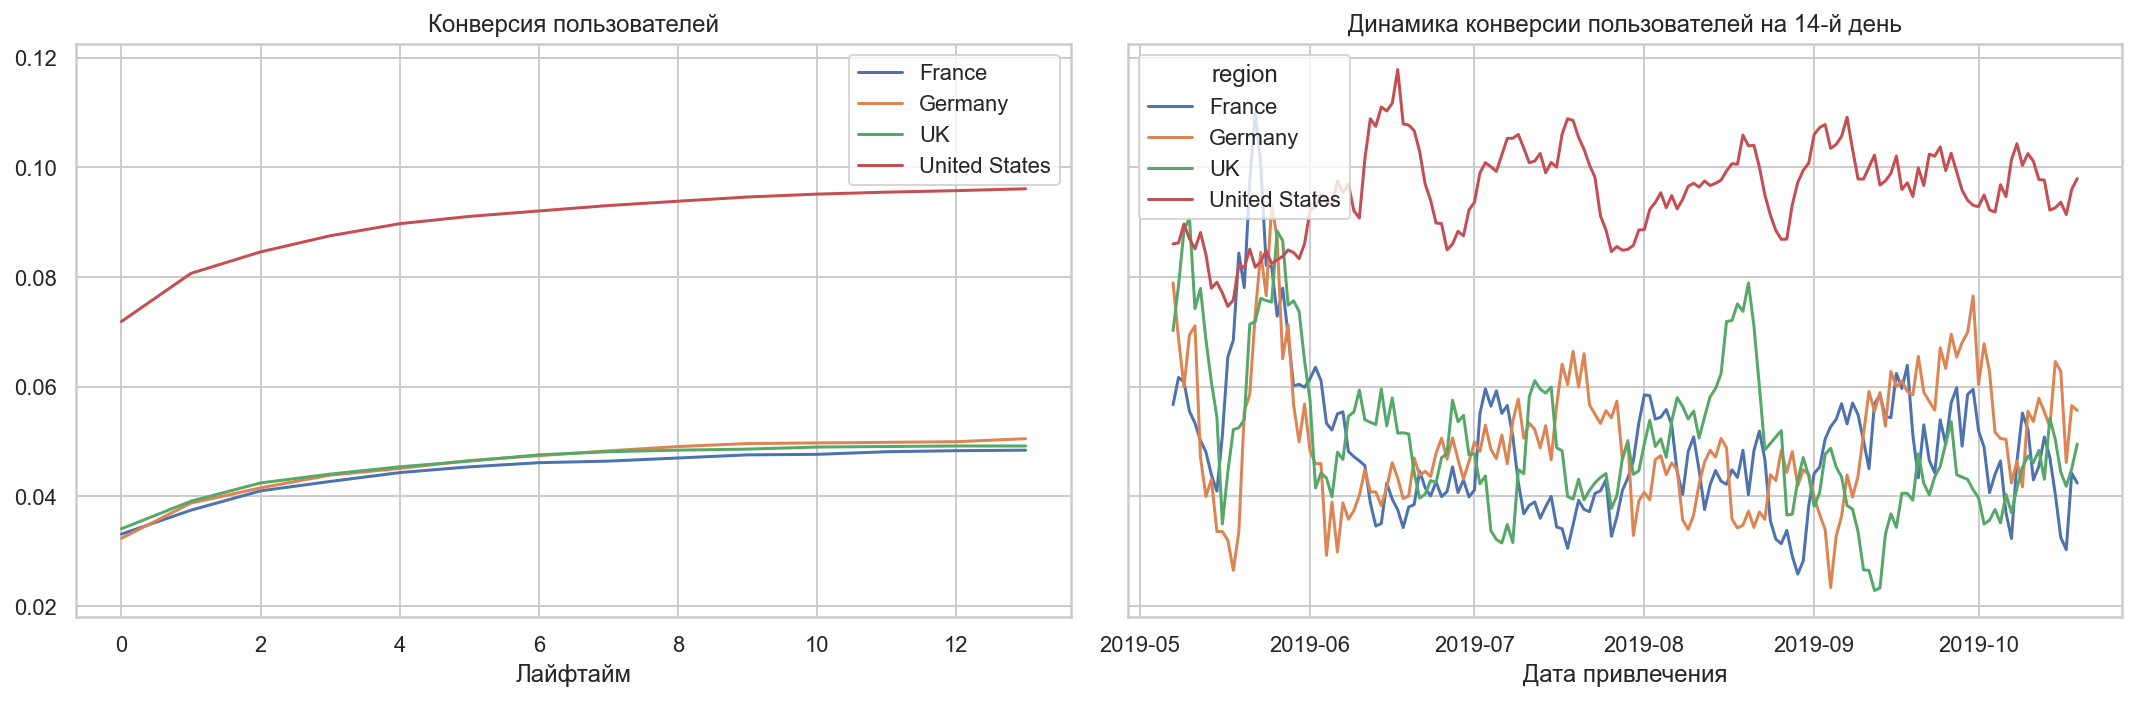

In [53]:
#рассмотрим конверсию с разбивкой по странам
dimensions = ['region']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    non_organic_profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Судя по графикам, **пользователи из США** конвертируются лучше всего **(в среднем 9,5% на конец 2й недели)**, причём **постоянно в диапазоне от 7,2% до 12% (по графику динамики конверсии).** Что же касается **пользователей из Франции, Германии и Великобритании (в среднем 5% на конец 2й недели)**, то у них конвертация чуть ниже **(в диапазоне от 2,5% до 11% по динамическому графику всего периода).**

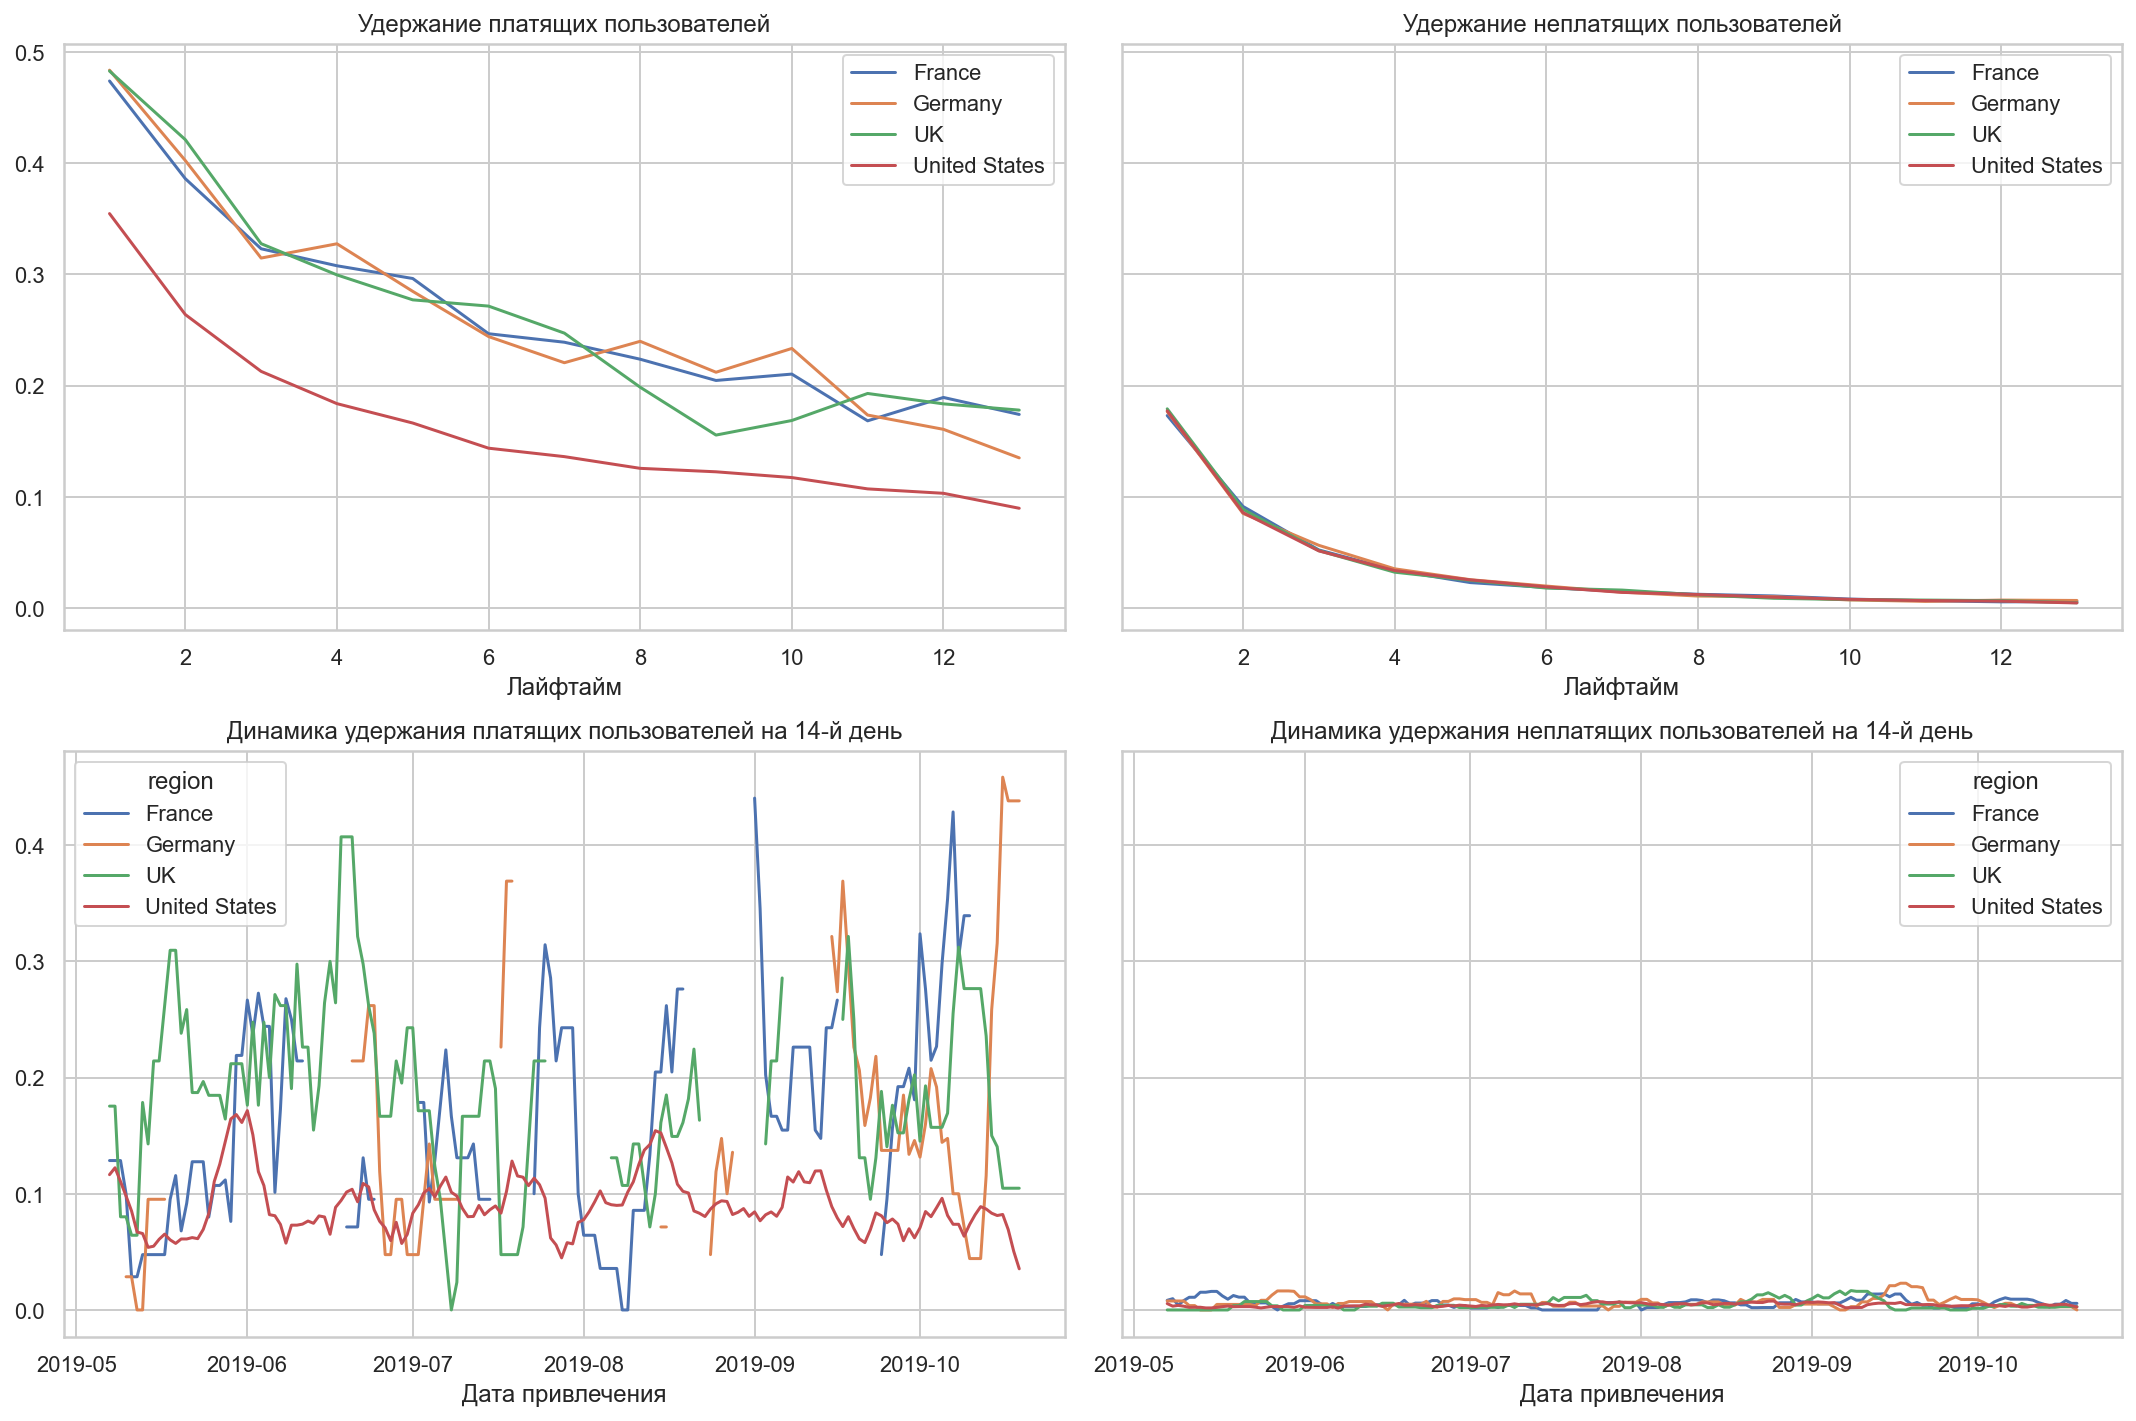

In [54]:
#рассмотрим удержание с разбивкой по странам
dimensions = ['region']
retention_raw, retention_grouped, retention_history = get_retention(
    non_organic_profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

В разрезе стран удержание неплатящих пользователей значительно хуже платящих. Но и те, и другие очень плохо удерживаются. **Платящие пользователи из США к концу 2й недели сокращаются на 25% с 35% до 10%. Удержание из других стран выглядит чуть лучше:** в начале лайфтайма оно составляет **почти 50% и к концу 2й недели снижается в среднем до 15-20%**. Это очень низкий показатель.
Возможно, причина тоже в какой-нибудь технической проблеме.

##### Графики конверсии и удержания с разбивкой по каналам

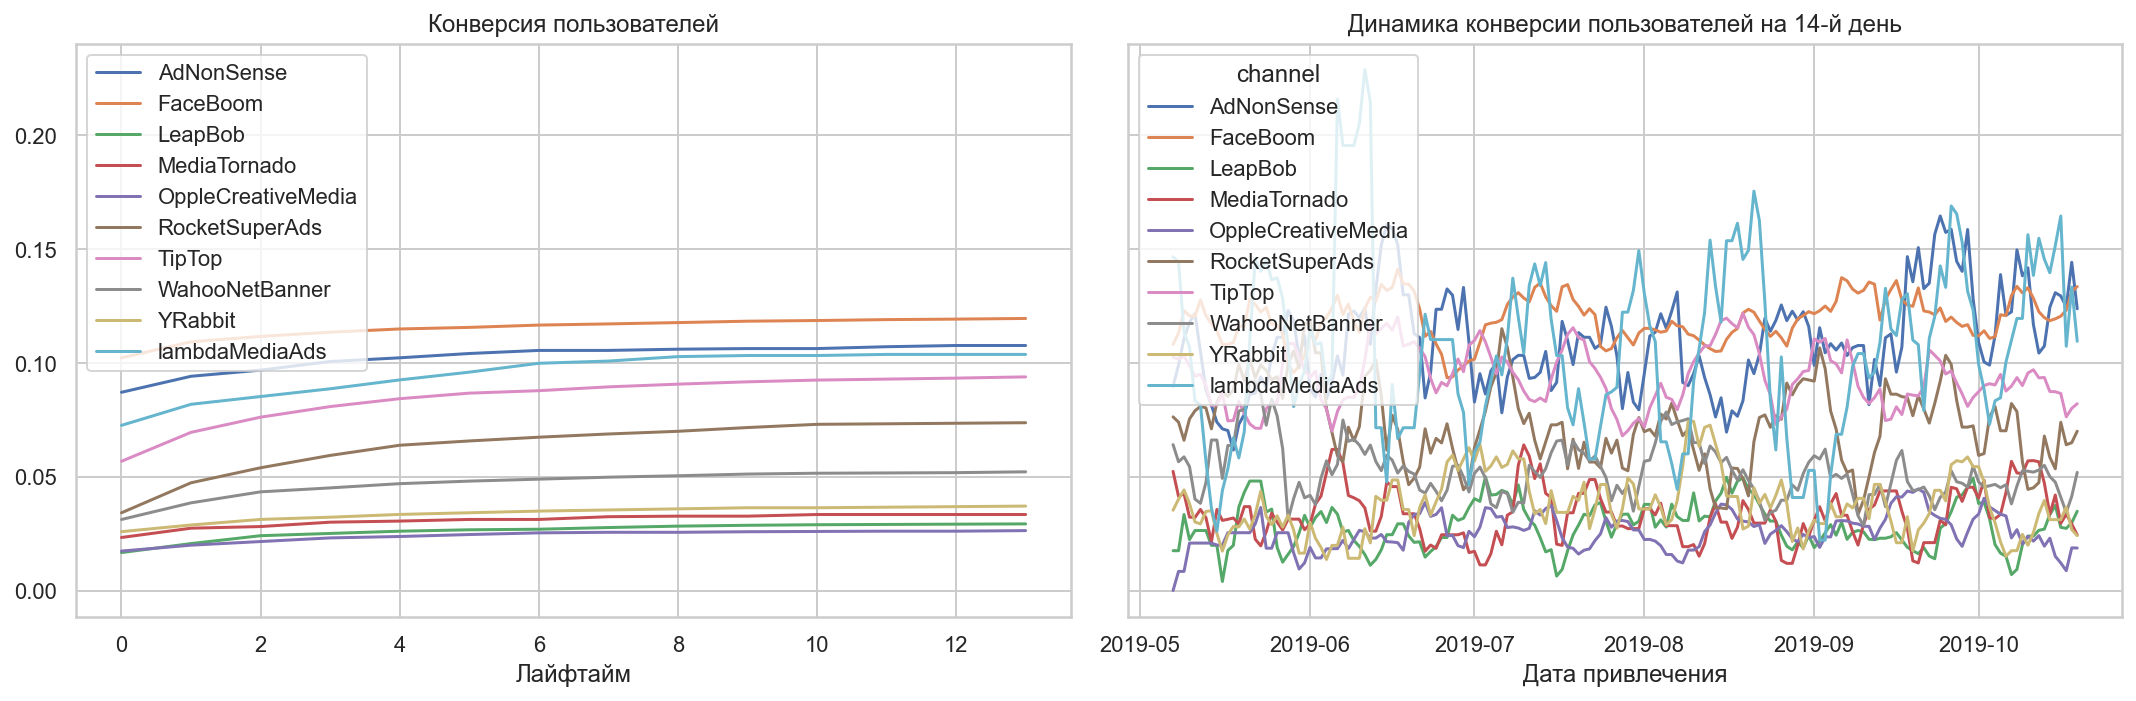

In [55]:
#рассмотрим конверсию с разбивкой по каналам продвижения
dimensions = ['channel']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    non_organic_profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Судя по графикам, **пользователи из каналов FaceBoom, AdNonSense и lambdaMediaAds** конвертируются очень хорошо **(выше 10% на конец 2й недели)**, причём постоянно в диапазоне **от 2,5% до 22,5%**. Самая высокая волатильность наблюдается **в канале lambdaMediaAds (в диапазоне от 2,5% до 22,5%)**. В канале **FaceBoom** волатильность значительнее ниже и стабильнее **(в диапазоне от 10% до 15%)**. **В канале AdNonSense** волатильность чуть выше: **в диапазоне от 7 до 17%.**

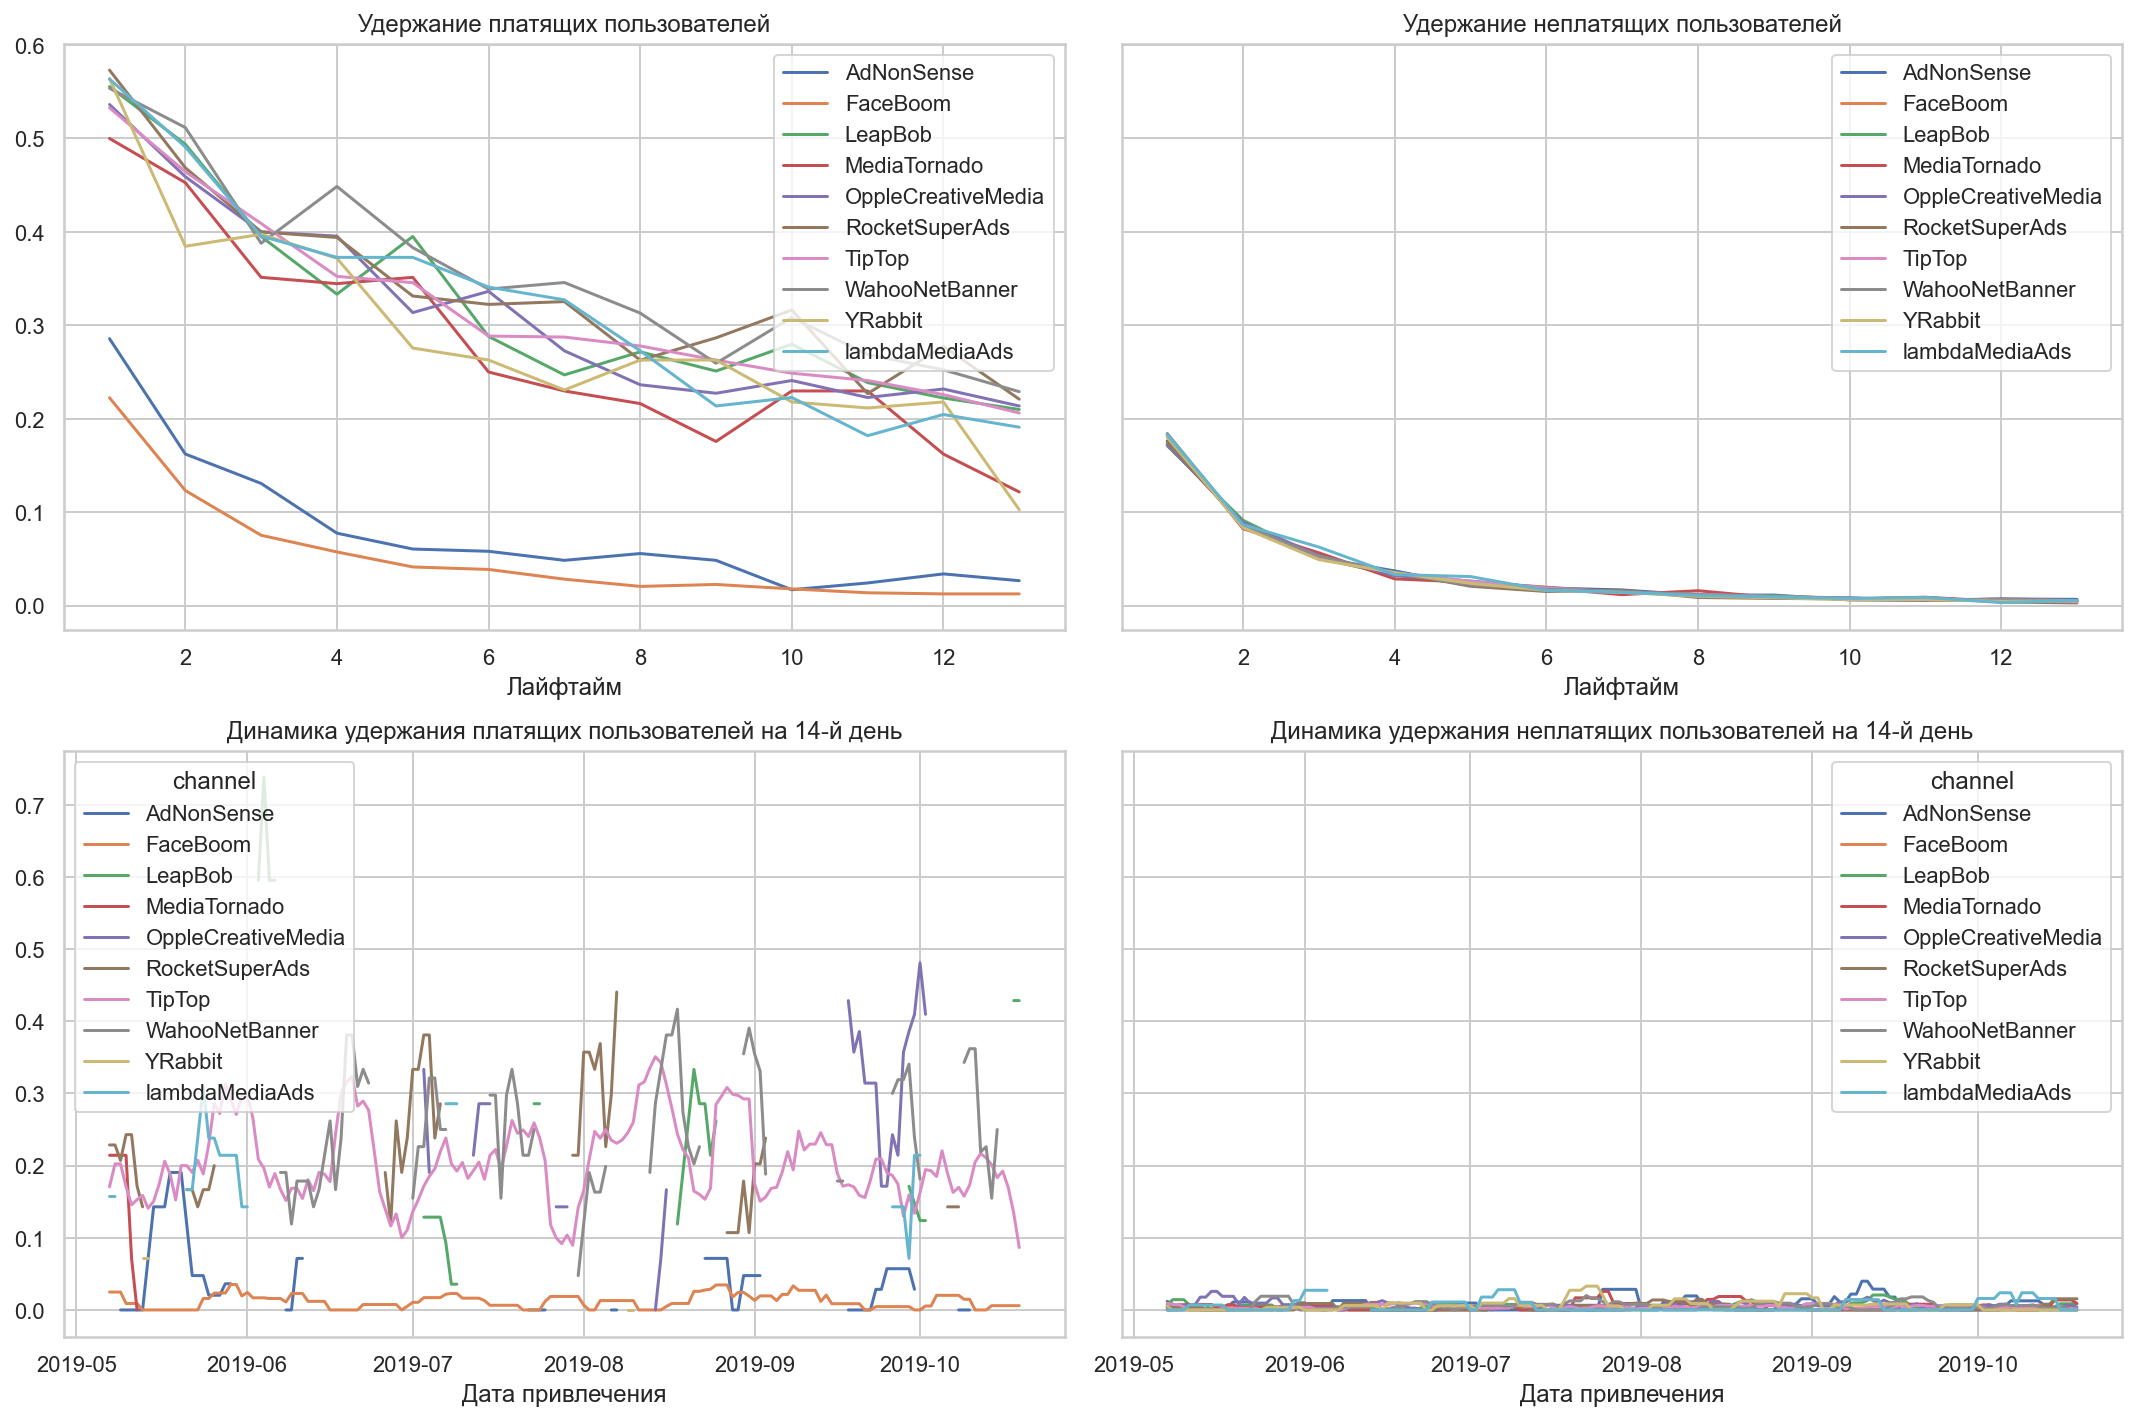

In [56]:
#рассмотрим удержание с разбивкой по каналам продвижения
dimensions = ['channel']
retention_raw, retention_grouped, retention_history = get_retention(
    non_organic_profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

В разрезе каналов продвижения удержание неплатящих пользователей также значительно хуже платящих. Но и те, и другие очень плохо удерживаются. **Все платящие пользователи всех каналов кроме FaceBoom и AdNonSense к концу 2й недели сокращаются с 57% до 20% в среднем.** Что же касается каналов **FaceBoom и AdNonSense**, то у них удержание еще хуже: к концу 2й недели снижается в среднем **с 25% практически до нуля.** Это очень низкий показатель.
Возможно, причина тоже в какой-нибудь технической проблеме.

## Выводы и рекомендации

**По графикам общей окупаемости:**

**`Хорошо`**
- LTV показатель достаточно стабилен на протяжении всего исследуемого периода. **Значит, дело не в ухудшении качества пользователей.**

**`Плохо`**

- Реклама не окупается. ROI в конце 2й недели составляет 80%. 
- CAC нестабилен. **Возможно, дело в увеличении рекламного бюджета.**



**По странам:**

**`Хорошо`**

Чаще всего платящие посетители приходят из **США (6%), из Германии и Великобритании (по 3,2% каждая).**

По графикам окупаемости в **разрезе стран**:
- **LTV к концу 2й недели достигает 100% только в США.** Если рассматривать LTV в динамике, то самый стабильный наблюдается как раз в США (в диапазоне от 0,8 до 1,35). Самая высокая волатильность и максимальные значения LTV - у Великобритании (от 0,4 до 1,4). **Это означает, что из США и Великобритании приходят самые качественные пользователи ("покупающие").**

Судя по графикам, **пользователи из США** конвертируются лучше всего **(в среднем 9,5% на конец 2й недели)**, причём **постоянно в диапазоне от 7,2% до 12% (по графику динамики конверсии).** Что же касается **пользователей из Франции, Германии и Великобритании (в среднем 5% на конец 2й недели)**, то у них конвертация чуть ниже **(в диапазоне от 2,5% до 11% по динамическому графику всего периода).**

**`Плохо`**

По графикам окупаемости в **разрезе стран**:
- **Стабильный CAC наблюдается у всех стран (0,4 пункта), кроме США**. **Стоимость привлечения пользователей из стран США** на рассматриваемом временном периоде растет месяц к месяцу и к концу октября **достигает 1,7 пунктов.** Это значит, что именно в привлечение пользователей из этой страны компания платит больше всего денег.
- Что любопытно, это именно привлечение пользователей из США совершенно не окупается, **в отличие от других стран, у которых ROI находится в районе 1,5 пунктов (выручка превышает маркетинговые затраты в 1,5 раза)**.
- Рассматривая ROI в динамике, мы видим, что с каждым месяцем окупаемость привлечения пользователей из США снижается. **У остальных стран практически на всем периоде показатель находится выше уровня окупаемости. Максимальные значения наблюдаются у Великобритании (3,2 и 3,3 пункта в середине июля и середине августа).** 

В разрезе стран удержание неплатящих пользователей значительно хуже платящих. Но и те, и другие очень плохо удерживаются. **Платящие пользователи из США к концу 2й недели сокращаются на 25% с 35% до 10%. Удержание из других стран выглядит чуть лучше:** в начале лайфтайма оно составляет **почти 50% и к концу 2й недели снижается в среднем до 15-20%**. Это очень низкий показатель.

**Рекомендации**
Из США платящие пользователи приходят чаще всего и приносят больше всего денег (лучше всего конвертируются). Возможно, это связано с вливаниями рекламных денег именно в пользователей этой страны. При этом, привлечение пользователей из США не стабильно и дороже всего приходится компании, в отличие от других стран. Привлечение пользователей из США совершенно не окупается. Окупаемость снижается месяц от месяца. У других же стран показатель окупаемости находится выше уровня окупаемости. Максимальные значения наблюдаются у Великобритании. Удержание пользователей из США сокращается к концу 2й недели быстрее и сильнее, чем пользователей из других стран.

Лучше направить рекламный бюджет на привлечение клиентов из других стран, например, из Великобритании. И значительно снизить его на привлечение клиентов из США, так как привлечение клиентов из этой страны требует больше затрат и они в результате не окупаются.


**По каналам продвижения:**

**`Хорошо`**

Каналы продвижения **FaceBoom и TipTop** больше всего привлекают пользователей **(29 и 19,5 тысяч человек соответственно)**. Но наиболее популярные каналы продвижения для **платящих пользователей** - это **FaceBoom (12,2% платящих пользователей) и AdNonSense (11,3% платящих пользователей).** 

По графикам окупаемости в **разрезе каналов привлечения**:
- **LTV к концу 2й недели выше 100% только у канала TipTop и lambdaMediaAds.** Если рассматривать LTV в динамике, то самый высокий наблюдается у lambdaMediaAds на протяжении практически всего рассматриваемого периода. В июне он достигал 4,5-5 пунктов, когда в остальных каналах он находился в диапазоне от 0 до 2. Это означает, что через канал lambdaMediaAds приходят самые качественные пользователи ("покупающие").

- Рассматривая ROI в динамике, мы видим, что **максимум окупаемости достигаем в канале YRabbit в период с середины июня по середину августа (более 7 пунктов в середине июля), а также в канале lambdaMediaAds (в первой половине июня 6,4 пунктов) и MediaTornado (в середине сентября 5,7 пунктов).** 

Судя по графикам, **пользователи из каналов FaceBoom, AdNonSense и lambdaMediaAds** конвертируются очень хорошо **(выше 10% на конец 2й недели)**, причём постоянно в диапазоне **от 2,5% до 22,5%**. Самая высокая волатильность наблюдается **в канале lambdaMediaAds (в диапазоне от 2,5% до 22,5%)**. В канале **FaceBoom** волатильность значительнее ниже и стабильнее **(в диапазоне от 10% до 15%)**. **В канале AdNonSense** волатильность чуть выше: **в диапазоне от 7 до 17%.**

**`Плохо`**

Больше всего денег было потрачено на **2 канала: TipTop (почти 55 тысяч) и FaceBoom	(почти 32,5 тысячи).**

**Общий CAC на одного пользователя составляет 1.13.** Стоимость привлечения во всех каналах за исключением TipTop ниже общего CAC. Показатель CAC **для канала TipTop значительно превышает среднюю стоимость** привлечения и **составляет 2.8.**

По графикам окупаемости в **разрезе каналов привлечения**:
- При этом, реклама окупается по всем каналам, кроме **TipTop, FaceBoom и AdNonSense**. ROI в конце 2й недели по всем остальным каналам **составляет 150-200% (выручка превышает маркетинговые затраты в 1,5-2 раза)**.
- **CAC стабилен во всех каналах, кроме TipTop**. Его динамика ступенчатая от месяца к месяцу. **Это значит, что именно в этот канал вливают каждый месяц все больше и больше денег.**

В разрезе каналов продвижения удержание неплатящих пользователей также значительно хуже платящих. Но и те, и другие очень плохо удерживаются. **Все платящие пользователи всех каналов кроме FaceBoom и AdNonSense к концу 2й недели сокращаются с 57% до 20% в среднем.** Что же касается каналов **FaceBoom и AdNonSense**, то у них удержание еще хуже: к концу 2й недели снижается в среднем **с 25% практически до нуля.** Это очень низкий показатель.
Возможно, причина тоже в какой-нибудь технической проблеме.

**Рекомендации**

Наиболее популярные каналы продвижения среди **платящих пользователей** - это **FaceBoom и AdNonSense (Они чаще и на большие суммы делают покупки)**.

При этом, если говорить о рекламных кампаниях и показателе LTV, то более привлекательными каналами оказались каналы **TipTop и lambdaMediaAds.** Но нельзя сказать, что канал **TipTop** сам по себе интересен пользователям, так как в него больше всего вливается денег (как и в канал FaceBoom). Стоимость привлечения клиентов через этот канал выше всех остальных. Реклама через этот канал не окупается, **как и через каналы FaceBoom и AdNonSense**. При этом, выручка по остальным каналам выше затрат в 1,5-2 раза. 

Также есть проблема с удержанием пользователей по всем каналам, но самая большая проблема с удержанием у каналов **FaceBoom и AdNonSense**. Она практически нулевая.

Через **канал lambdaMediaAds** приходят самые качественные пользователи ("покупающие"). Максимум окупаемости достигаем **в каналах YRabbit, lambdaMediaAds и MediaTornado.** Пользователи **из каналов FaceBoom, AdNonSense и lambdaMediaAds** конвертируются лучше всего.

В первую очередь необходимо решить проблему с удержанием клиентов по всем каналам. Видимо, это системная проблема.

Необходимо перенаправить маркетинговый бюджет с каналов **TipTop, FaceBoom и AdNonSense** (так как реклама в них совершенно не окупается) на каналы **YRabbit, lambdaMediaAds и MediaTornado.** У них лучшая окупаемость, у канала **lambdaMediaAds** самые качественные "покупающие" пользователи, а также они легче всего конвертируются.


**По используемым устройствам:**

**`Хорошо`**

Чаще всего платящие пользователи пользуются **Mac (5,6%), IPhone (5,5%) и Android (5%).** В результате анализа LTV, мы выявили, что **через устройства Mac приходят самые качественные пользователи ("покупающие").**

К концу второй недели привлечение пользователей **только через устройства PC** окупается и составляет **почти 1,1**.

Судя по графикам, **пользователи Mac, iPhone и Android конвертируются очень хорошо, причём постоянно в диапазоне от 6% до 11%.** Что же касается **пользователей PC**, то у них конвертация чуть ниже **(в диапазоне от 4% до 9,5%).**

**`Плохо`**

**CAC у всех устройств нестабильный: он растет от месяца к месяцу**. **Самое дорогое** привлечение пользователей происходит через устройства **Mac и iPhone (1,5 пунктов к концу периода), самое дешевое - у PC (0,9 пунктов** к концу рассматриваемого периода).

Самыми убыточными являются устройства **Mac и iPhone**.

Рассматривая ROI в динамике, мы видим, что с каждым месяцем окупаемость привлечения пользователей через все устройства снижается. **Безубыточность устройств PC достигалась только за счет первых 2/3 рассматриваемого периода (с мая по середину августа).** Далее и у него доходность уходит ниже уровня окупаемости.

В разрезе устройств удержание неплатящих пользователей значительно хуже платящих. Но и те, и другие очень плохо удерживаются. **Платящие пользователи к концу 2й недели сокращаются с 40% до 10% по всем девайсам.** Это очень низкий показатель.

**Рекомендации**
Так как, платящие пользователи чаще пользуются **Mac, IPhone и Android**, а также лучше конвертируются, необходимо сделать акцент именно на пользователей этих устройств. При этом, у нас есть проблема: по этим устройствам рекламные кампании убыточны. **То есть, устройства перспективные, а реклама по ним, почему-то не окупается.** Возможно, это связано с какими-то техническими проблемами, потому что, если посмотреть на устройства **PC**, то они не пользуются популярностью у покупающих пользователей, при этом, только у них наблюдается прибыльность рекламных кампаний.